# 0.0 Imports

In [1]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from scipy import stats as ss
from IPython.display import Image
from IPython.core.display import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [4]:
# low_memory = False (ler todo o arquivo na mesma hora coloca na memoria)
df_sales_raw = pd.read_csv ('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv ('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
529444,605,5,2014-03-14,5355,422,1,0,0,0,d,a,10310.0,4.0,2003.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


# 1.0 DESCRICAO DOS DADOS

In [8]:
# é sempre bom em cada sessão fazer uma copy do dataframe
df1 = df_raw.copy()

## 1.1 Rename Columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new

## 1.2  Data Dimensions

In [10]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [11]:
# mudar o types da coluna date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [13]:
#competition_distance - distancia em metros da loja competidora proxima
    # uma das formas de eliminar os NAs é preenchendo as linhas faltantes
    # utilizando a lógica de que talvez  NA é pq a loja competidora está bem distante
    # e para isso irei preencher um valor qualquer 200000.0 (maior q o valor maximo do meu dataframe) 
    
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month - mes/ano que a loja competidora foi aberta
    # quando é mais de uma coluna coloca axis=1
    
df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month 
                                               if math.isnan(x['competition_open_since_month']) else 
                                               x['competition_open_since_month'], axis=1)

#competition_open_since_year  
df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year 
                                               if math.isnan(x['competition_open_since_year']) else      
                                               x['competition_open_since_year'], axis=1)                       
#promo2_since_week
df1['promo2_since_week']= df1.apply(lambda x: x['date'].week 
                                               if math.isnan(x['promo2_since_week']) else      
                                               x['promo2_since_week'], axis=1)  
#promo2_since_year   
df1['promo2_since_year']= df1.apply(lambda x: x['date'].year 
                                               if math.isnan(x['promo2_since_year']) else      
                                               x['promo2_since_year'], axis=1)
#promo_interval - intervalos consecutivos quando a promo2 foi iniciada
# dicionario indicando o numero dos meses
month_map = {1: 'Jan',
            2: 'Feb',
            3: 'Mar',
            4: 'Apr',
            5: 'May',
            6: 'Jun',
            7: 'Jul',
            8: 'Aug',
            9: 'Sept',
            10: 'Oct',
            11: 'Nov',
            12: 'Dec'}
df1['promo_interval'] = df1['promo_interval'].fillna(0)
    # assumption: criadno uma coluna onde indica o mes da coluna date     
df1['month_map'] = df1['date'].dt.month.map(month_map)

    # assumption: se o mes estiver presente na coluna 'promo_interval' logo tem promocao ativa naquela data 
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 
                                                            1 if x['month_map'] in x['promo_interval'].split(',') 
                                                            else 0, axis=1)

In [14]:
df1.sample(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
9024,105,4,2015-07-23,5191,604,1,0,0,0,a,c,6190.0,7.0,2015.0,1,23.0,2013.0,"Mar,Jun,Sept,Dec",Jul,0
278553,118,7,2014-11-16,0,0,0,0,0,0,d,c,3580.0,9.0,2012.0,0,46.0,2014.0,0,Nov,0


## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T
                  
# cocantenação dos dataframes
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.1 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

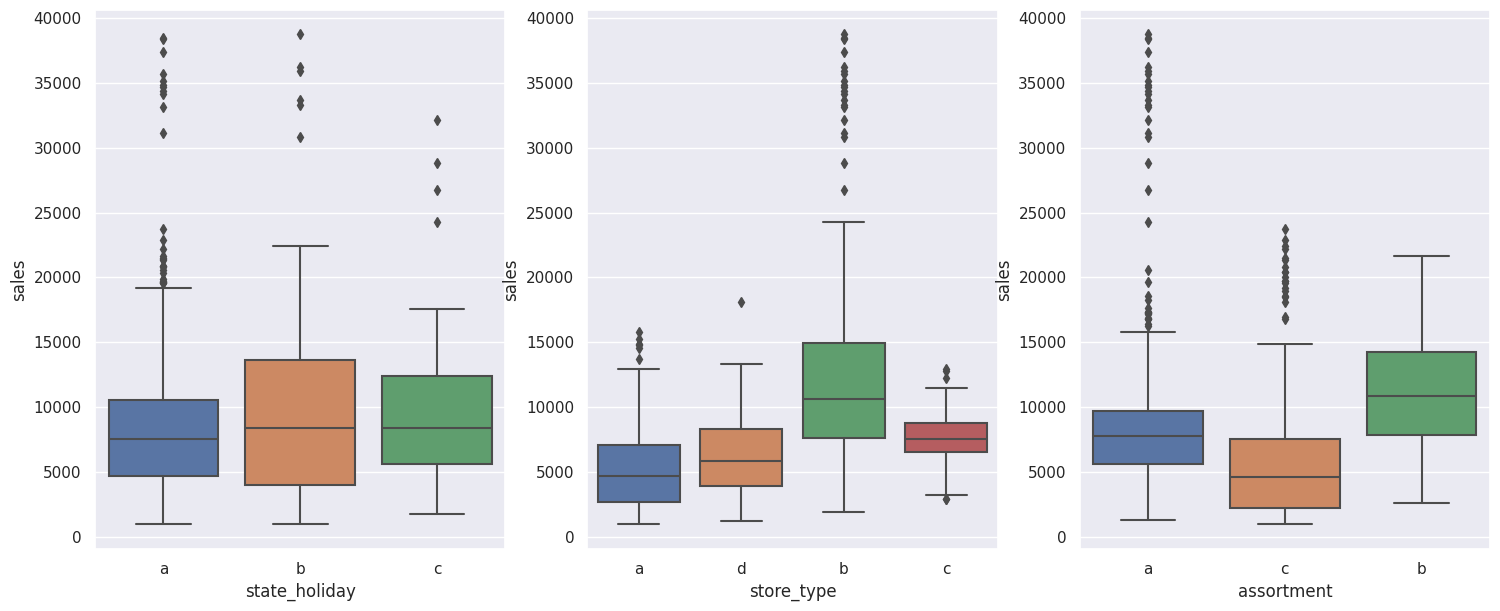

In [19]:
plt.figure(figsize=(18,7))
# filtrar o dataset
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales', data=aux)

# 2.0 - Feature Engineering

In [20]:
df2 = df1.copy()

In [21]:
## extraindo novas features da coluna date
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

## features de competition
# competition since - juntas o mes - ano
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'] , day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

## feature de promo
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# transformando em datetime
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

## feature assortment
df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 

# 3.0 - Filtragem das Variáveis

FILTRAGEM
**Restrições de acordo com o negócio**

SELEÇÃO
**Variáveis mais relevantes para o modelo desejado.**

In [22]:
df3 = df2.copy()

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 - Filtragem das linhas

In [24]:
# as restrições observadas para o negócio foram loja fechada e vendas nulas
df3 = df3[(df3['open'] != 0) & (df3['sales'] != 0 )]

## 3.2 - Seleção

In [25]:
# a coluna customers é uma restrição para o modelo, pois tem essa informação daqui 6 semanas
# a não ser que eu faça outro modelo de previsão para calcular a coluna customers daqui 6 semanas.
# então por isso, foi retirar essa coluna do meu dataset para fazer a predição de vendas daqui 6 semanas.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória de Dados - EDA

In [27]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

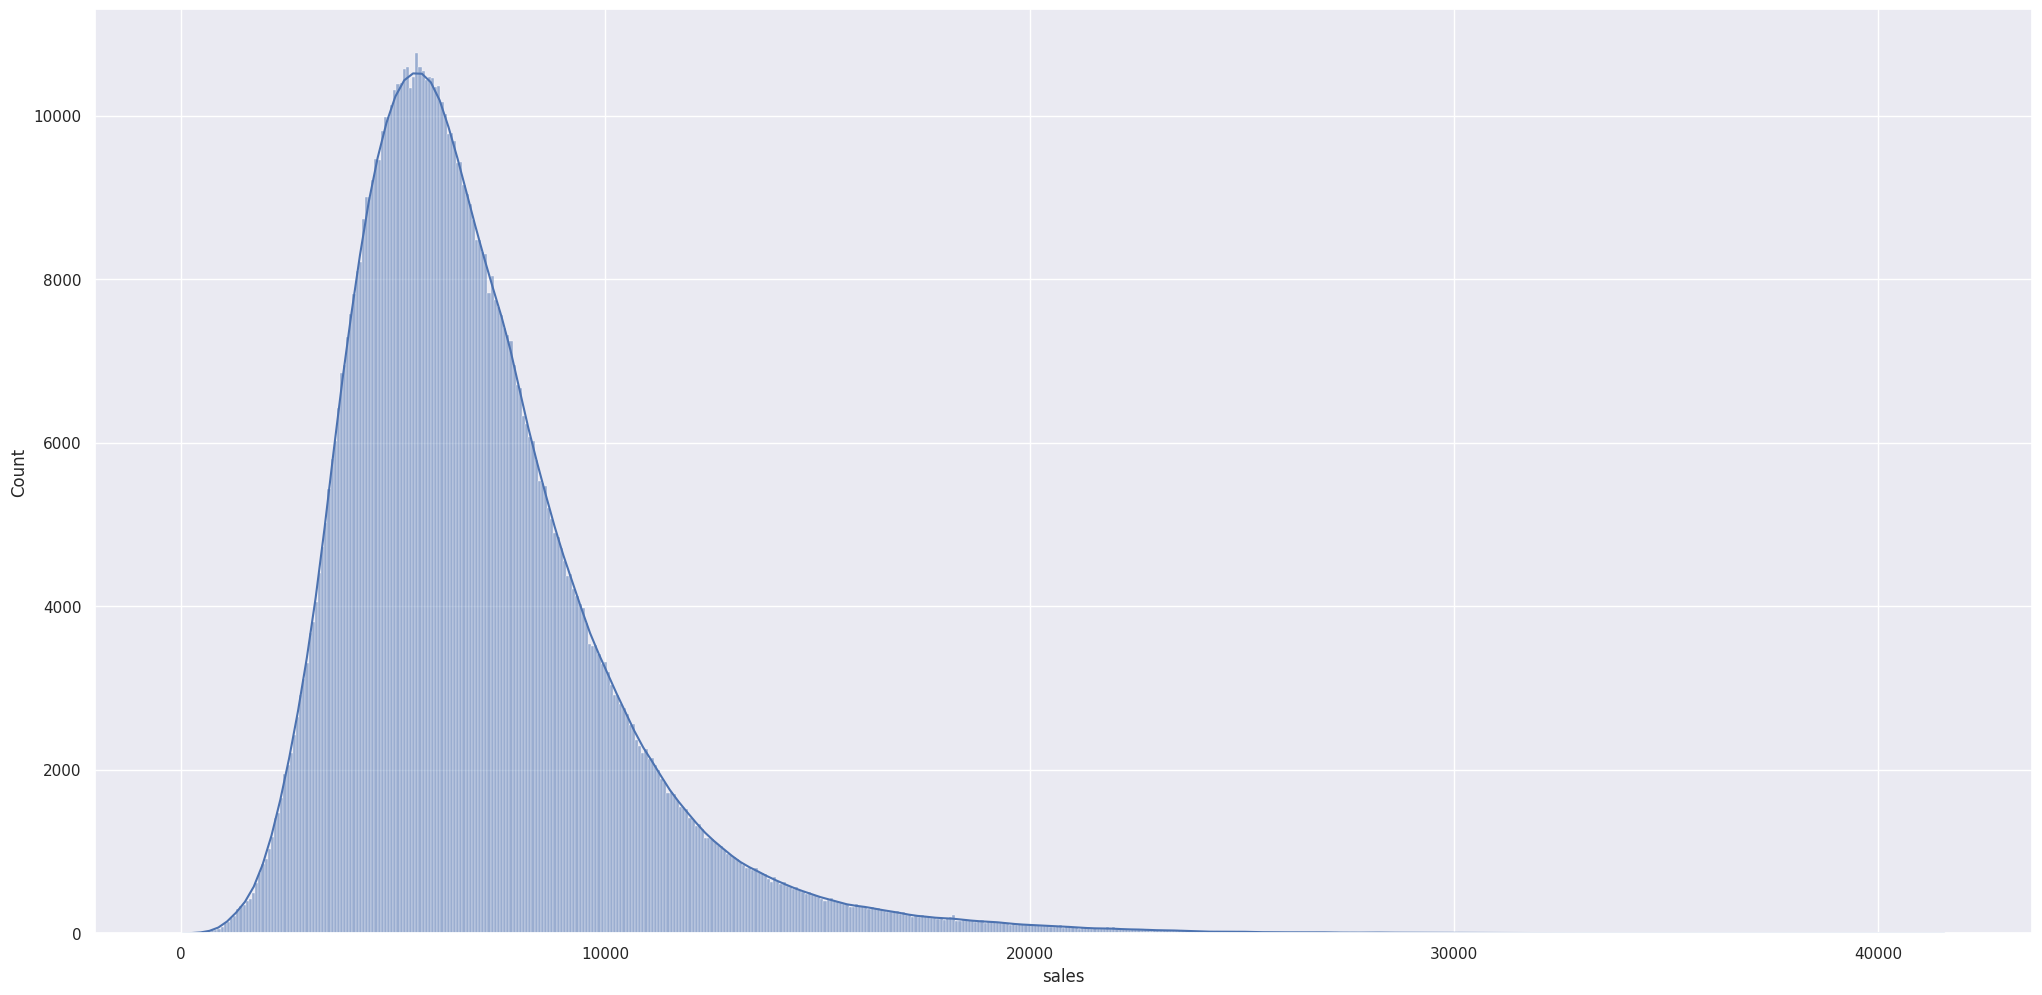

In [28]:
# a minha variavel resposavel pelo fenomeno é a coluna 'sales'
sns.histplot(df4['sales'], kde=True);
# kurtosis e skew? analisar

### 4.1.2 Numerical Variable

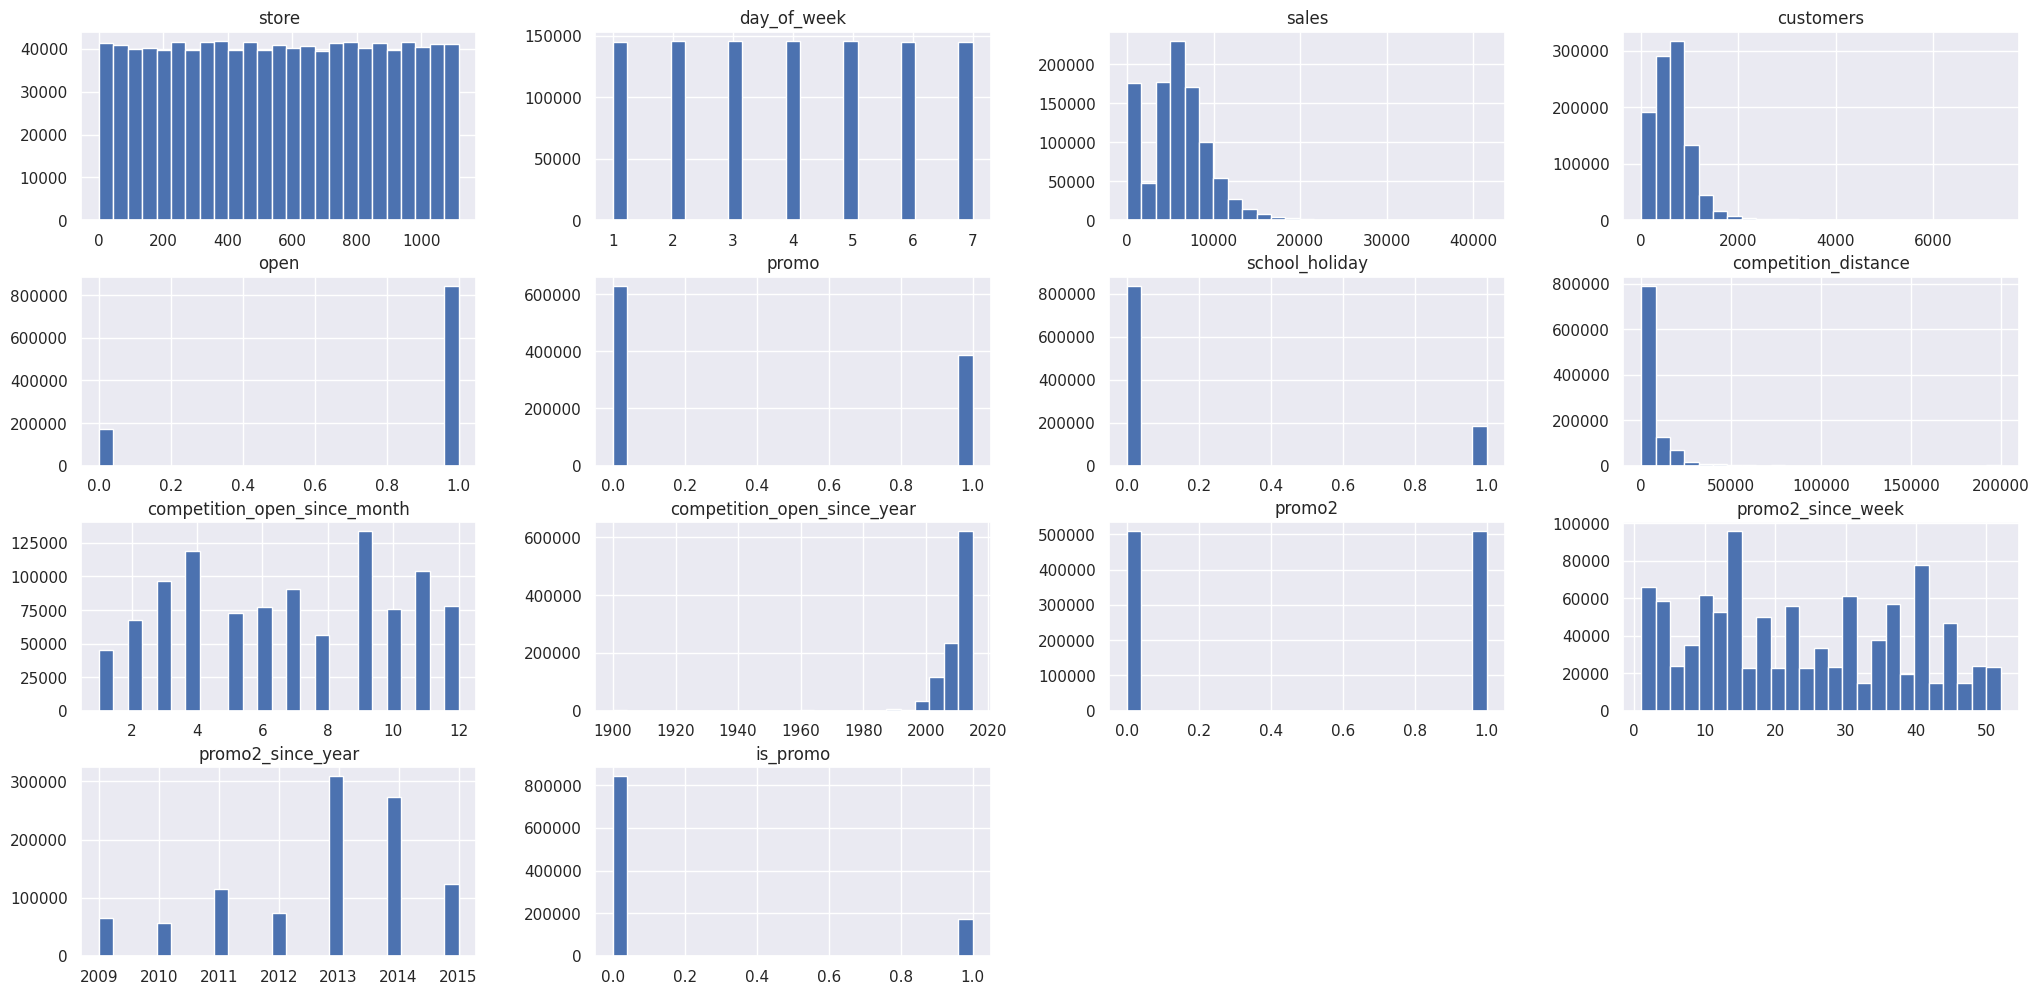

In [29]:

num_attributes.hist(bins=25);

### 4.1.2 Categorical Variable

In [30]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

<AxesSubplot: xlabel='sales', ylabel='Density'>

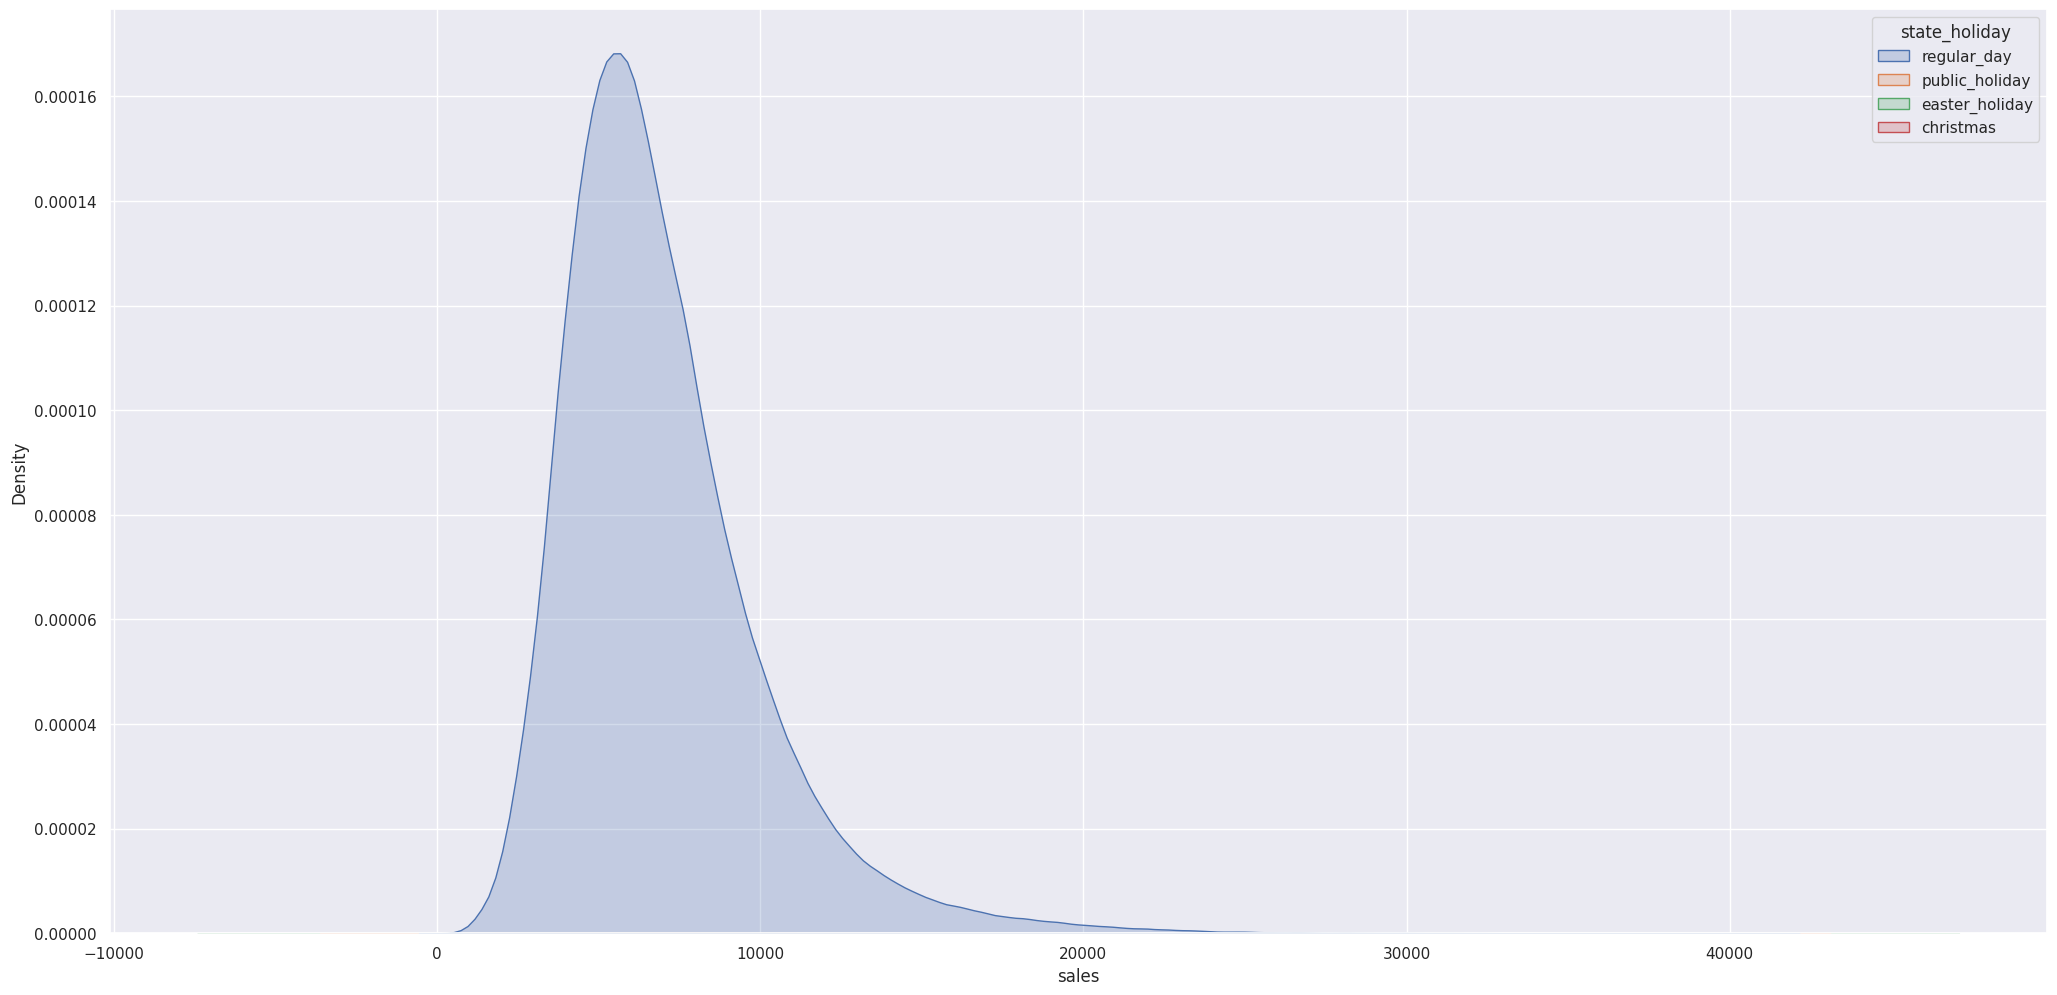

In [31]:
sns.kdeplot(df4, x= 'sales', hue=df4['state_holiday'], fill=True)

<AxesSubplot: xlabel='sales', ylabel='Density'>

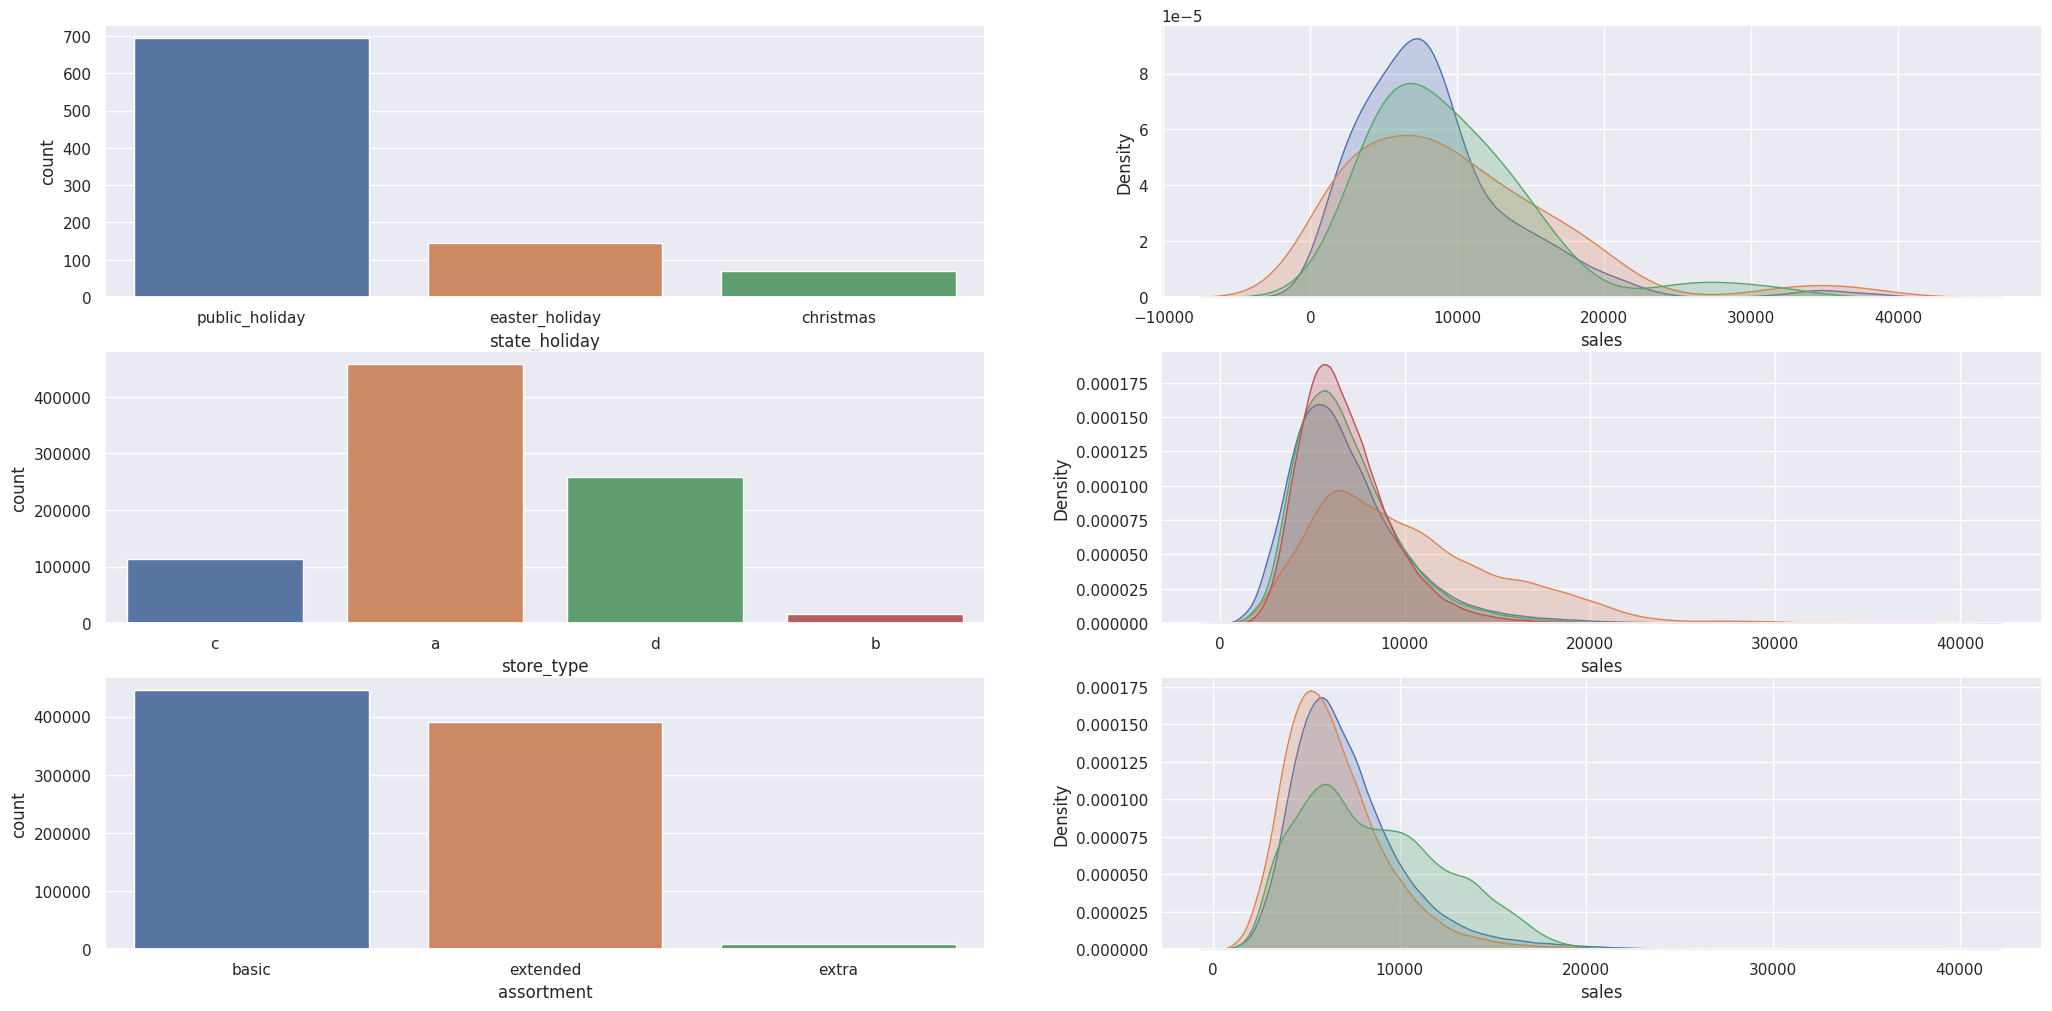

In [32]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x= a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], legend='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], legend='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], legend='christmas', fill=True)

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x = df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], legend='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], legend='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], legend='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], legend='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x = df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], legend='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], legend='basic',fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], legend='extra',fill=True )

## 4.2 Análise Bivariada

In [33]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [34]:
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


#### **H1. Lojas com maior sortimentos deveriam vender mais.**
**FALSA** Lojas com MENOR sortimento vende mais.

<AxesSubplot: xlabel='year_week'>

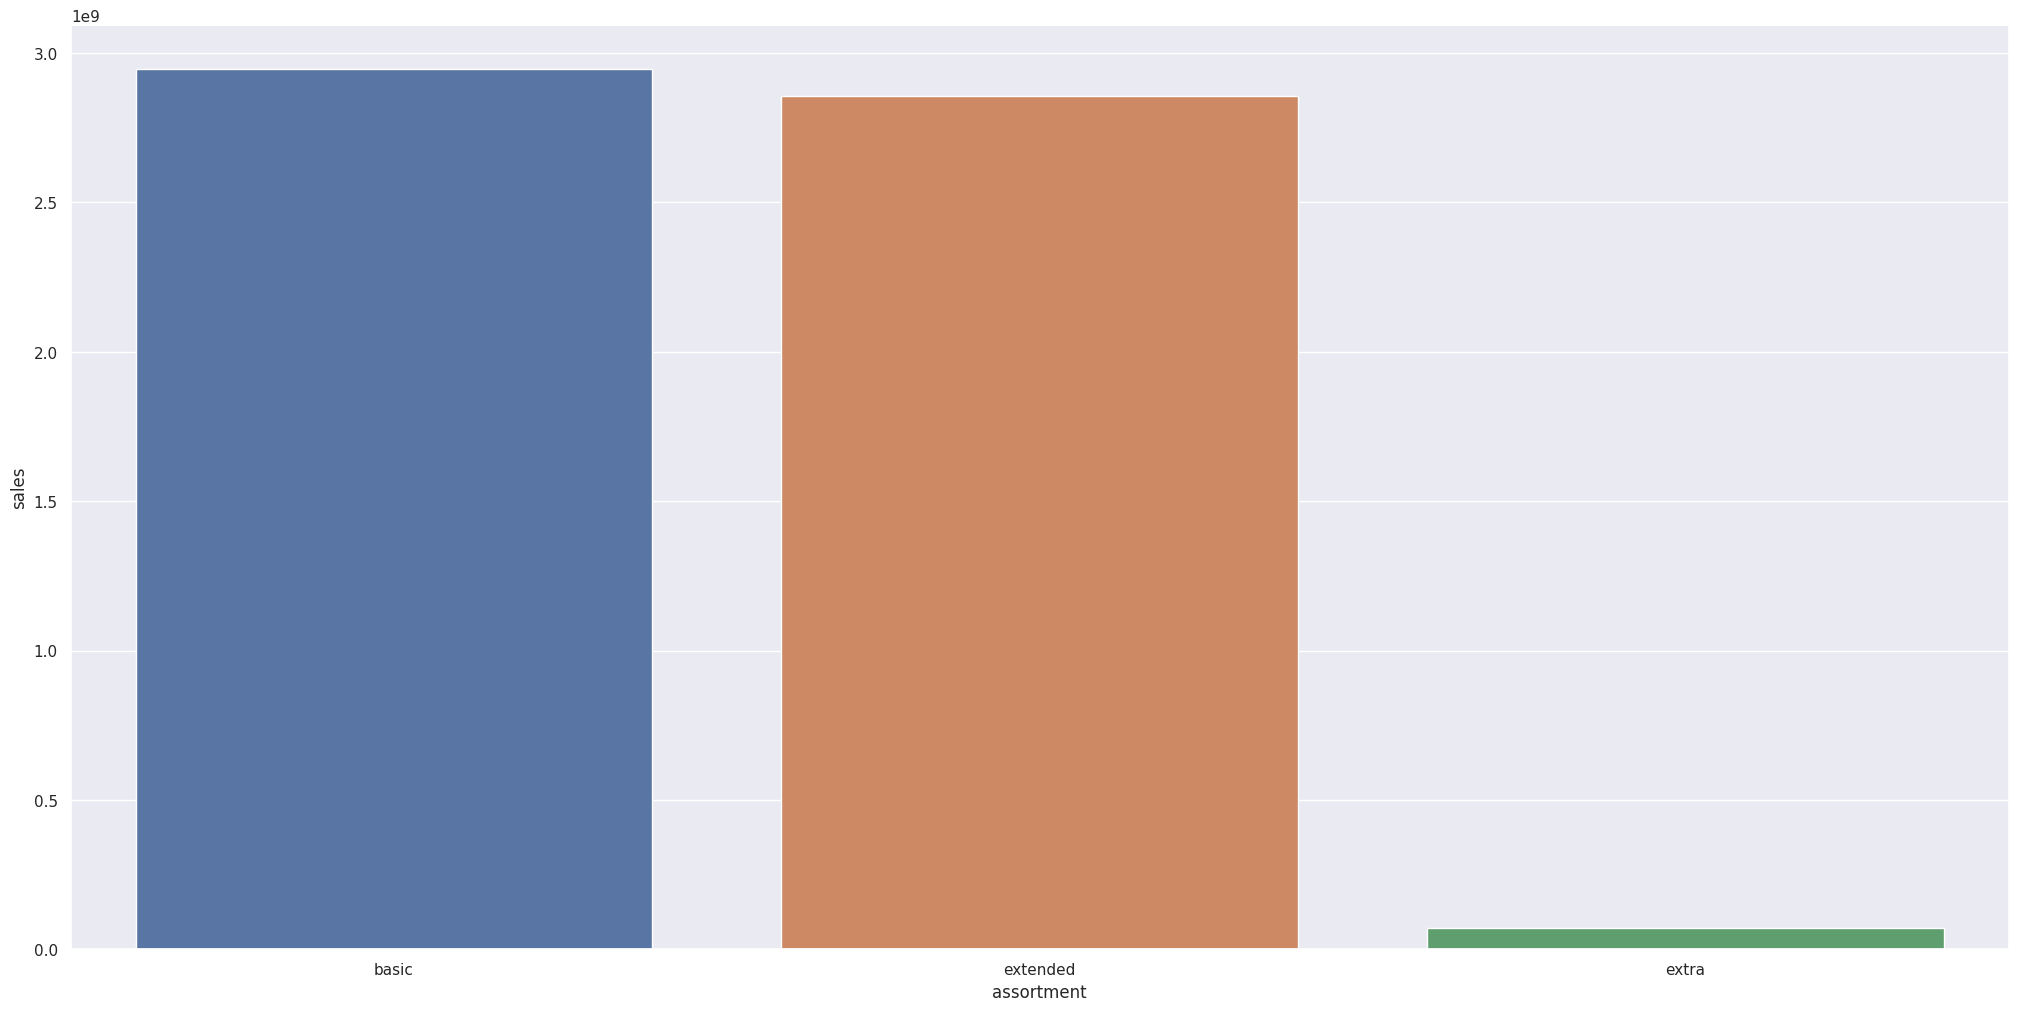

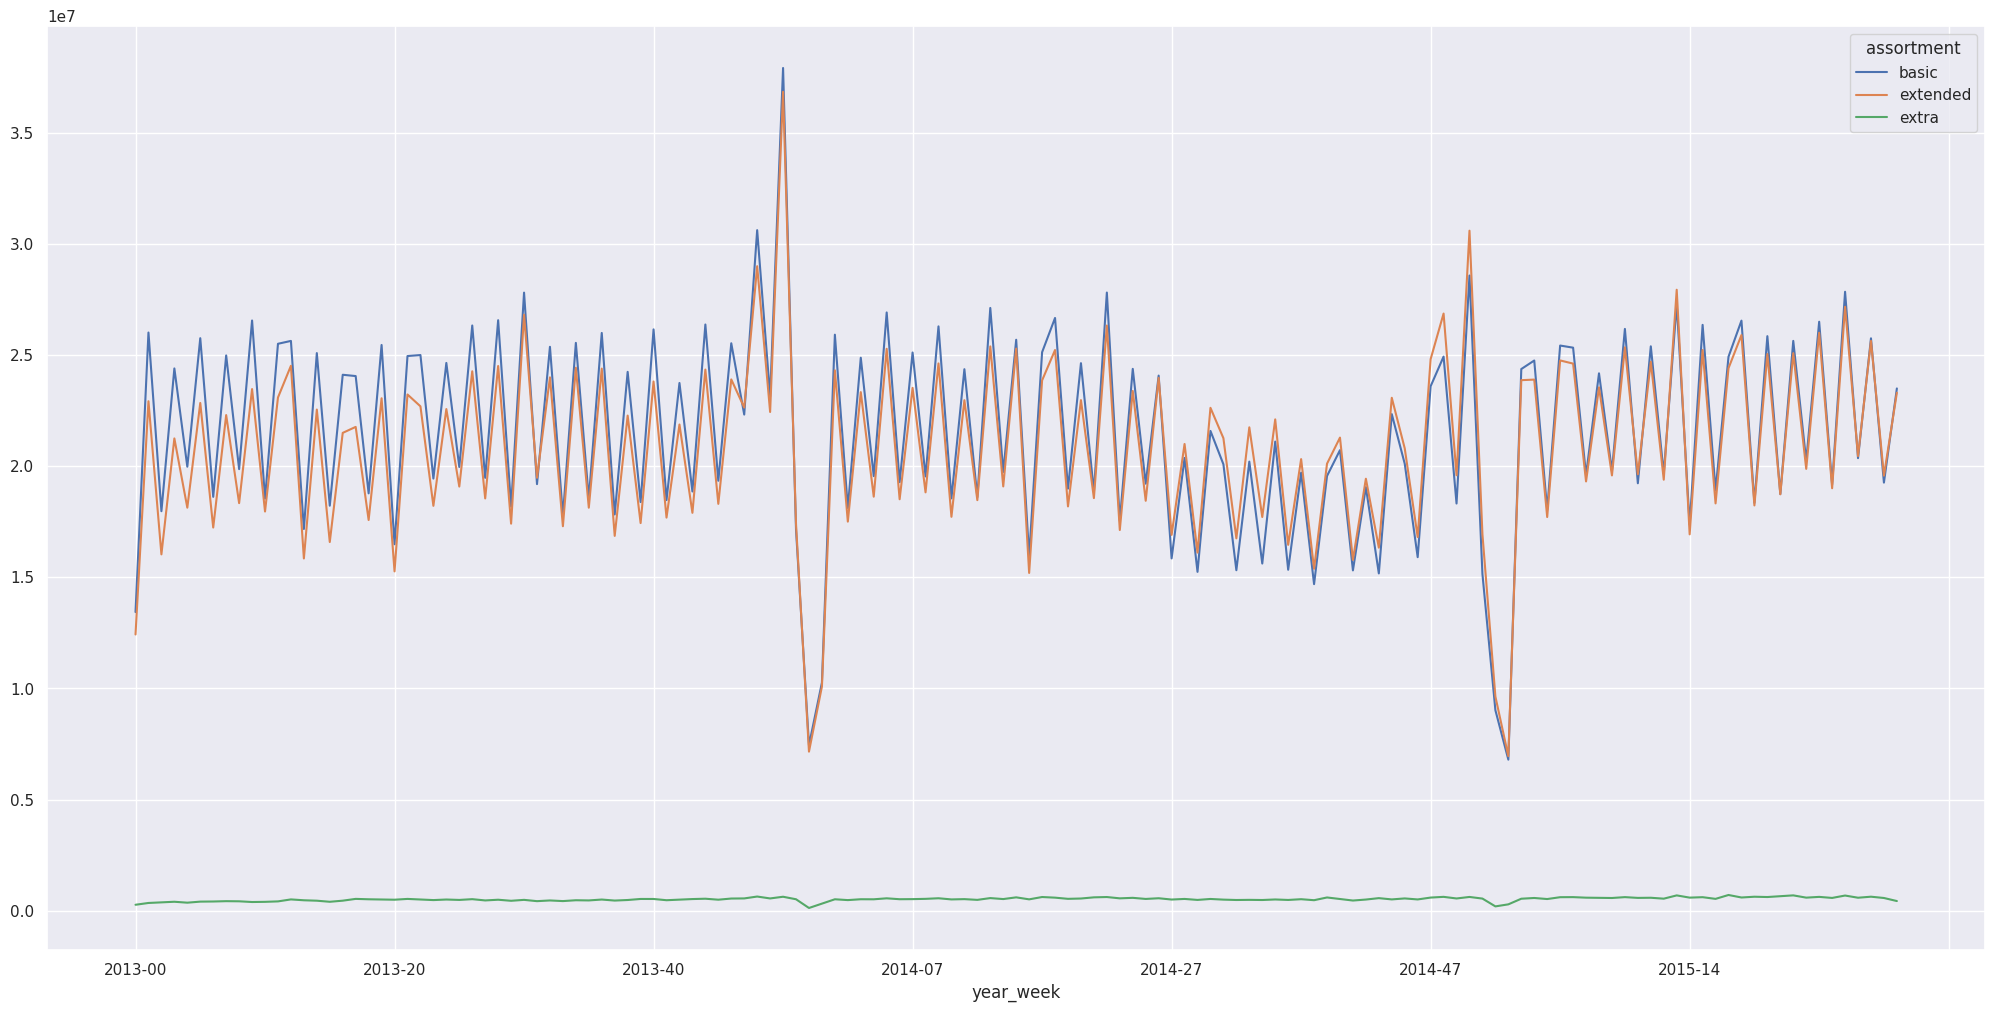

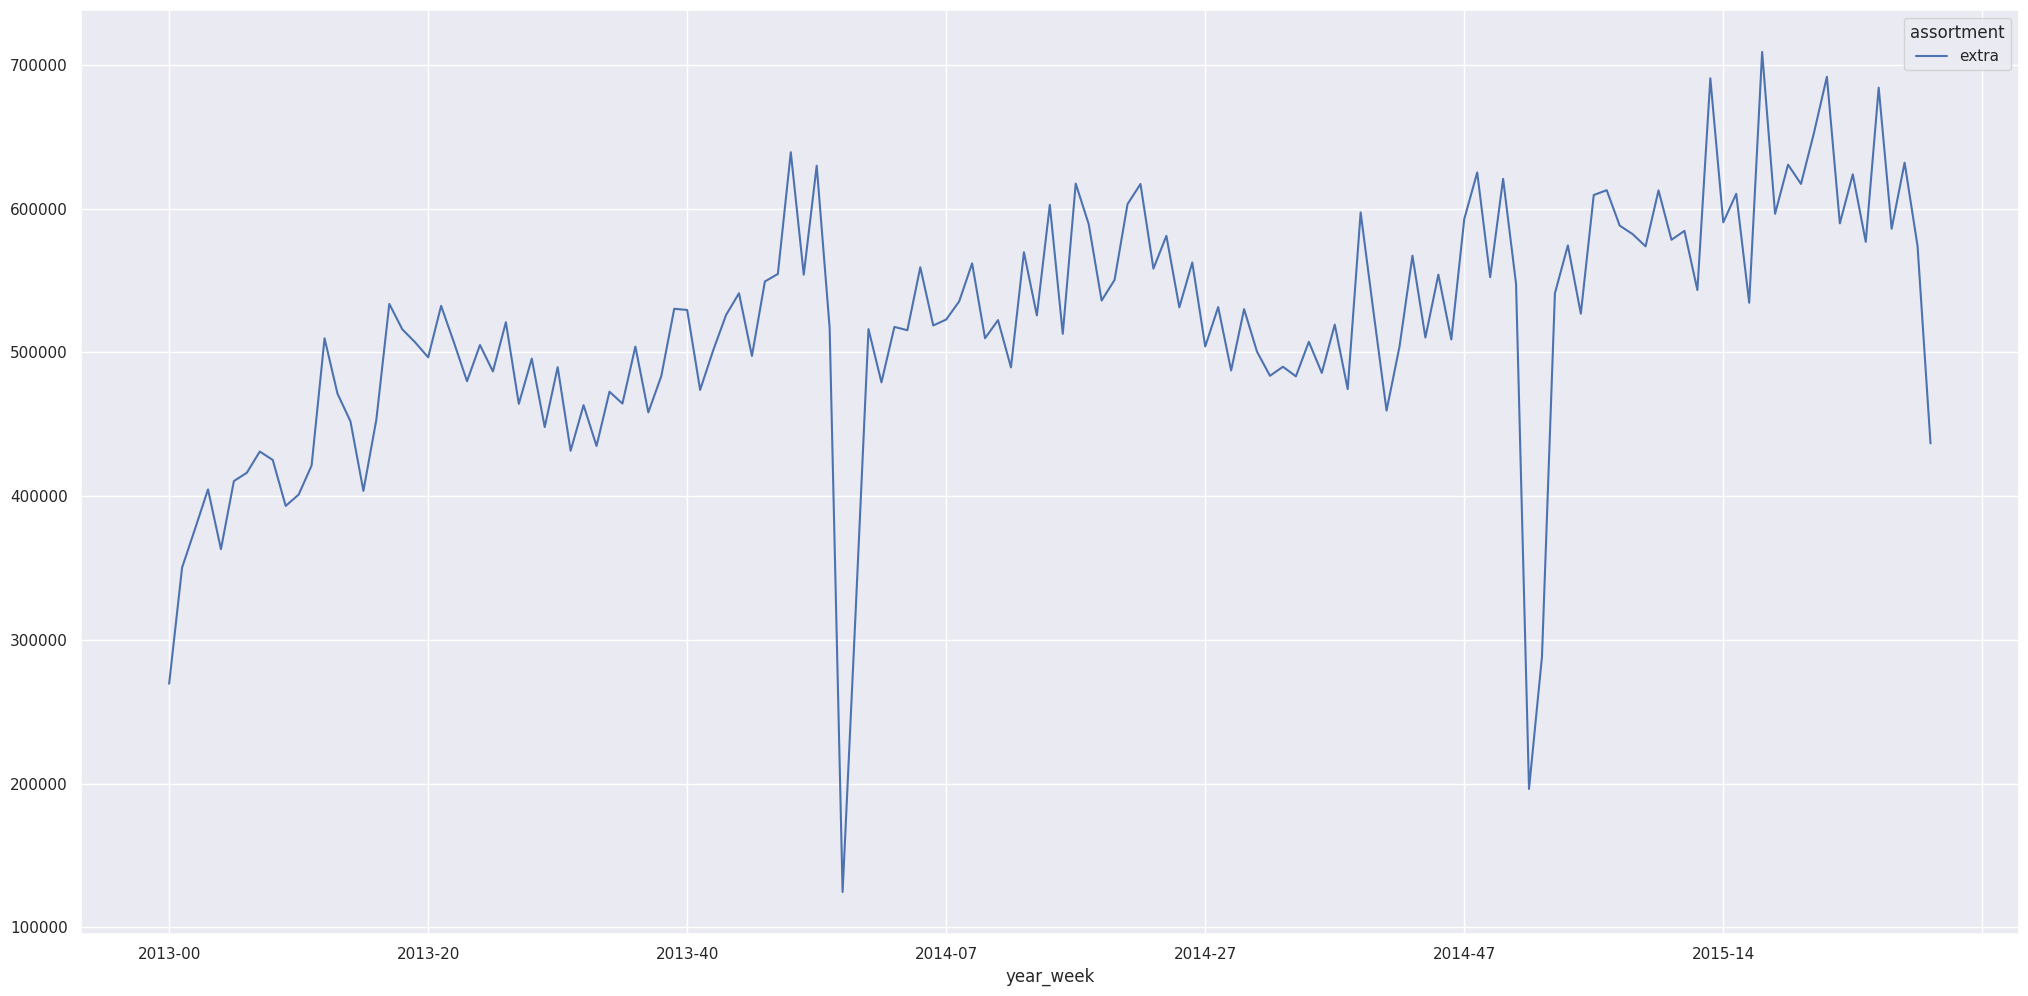

In [35]:
# para validar a hipotese é coloco o somatório de venda de cada sortemento 
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# preciso coonfirmar isso ao longo do tempo
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# observando apenas as oscilações de venda ao longo do tempo do assortment extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### **H2. Lojas com competidores mais próximos deveriam vender menos.**
**FALSA** Lojas com competidores mais próximos vendem MAIS.

/tmp/ipykernel_11259/3072804927.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


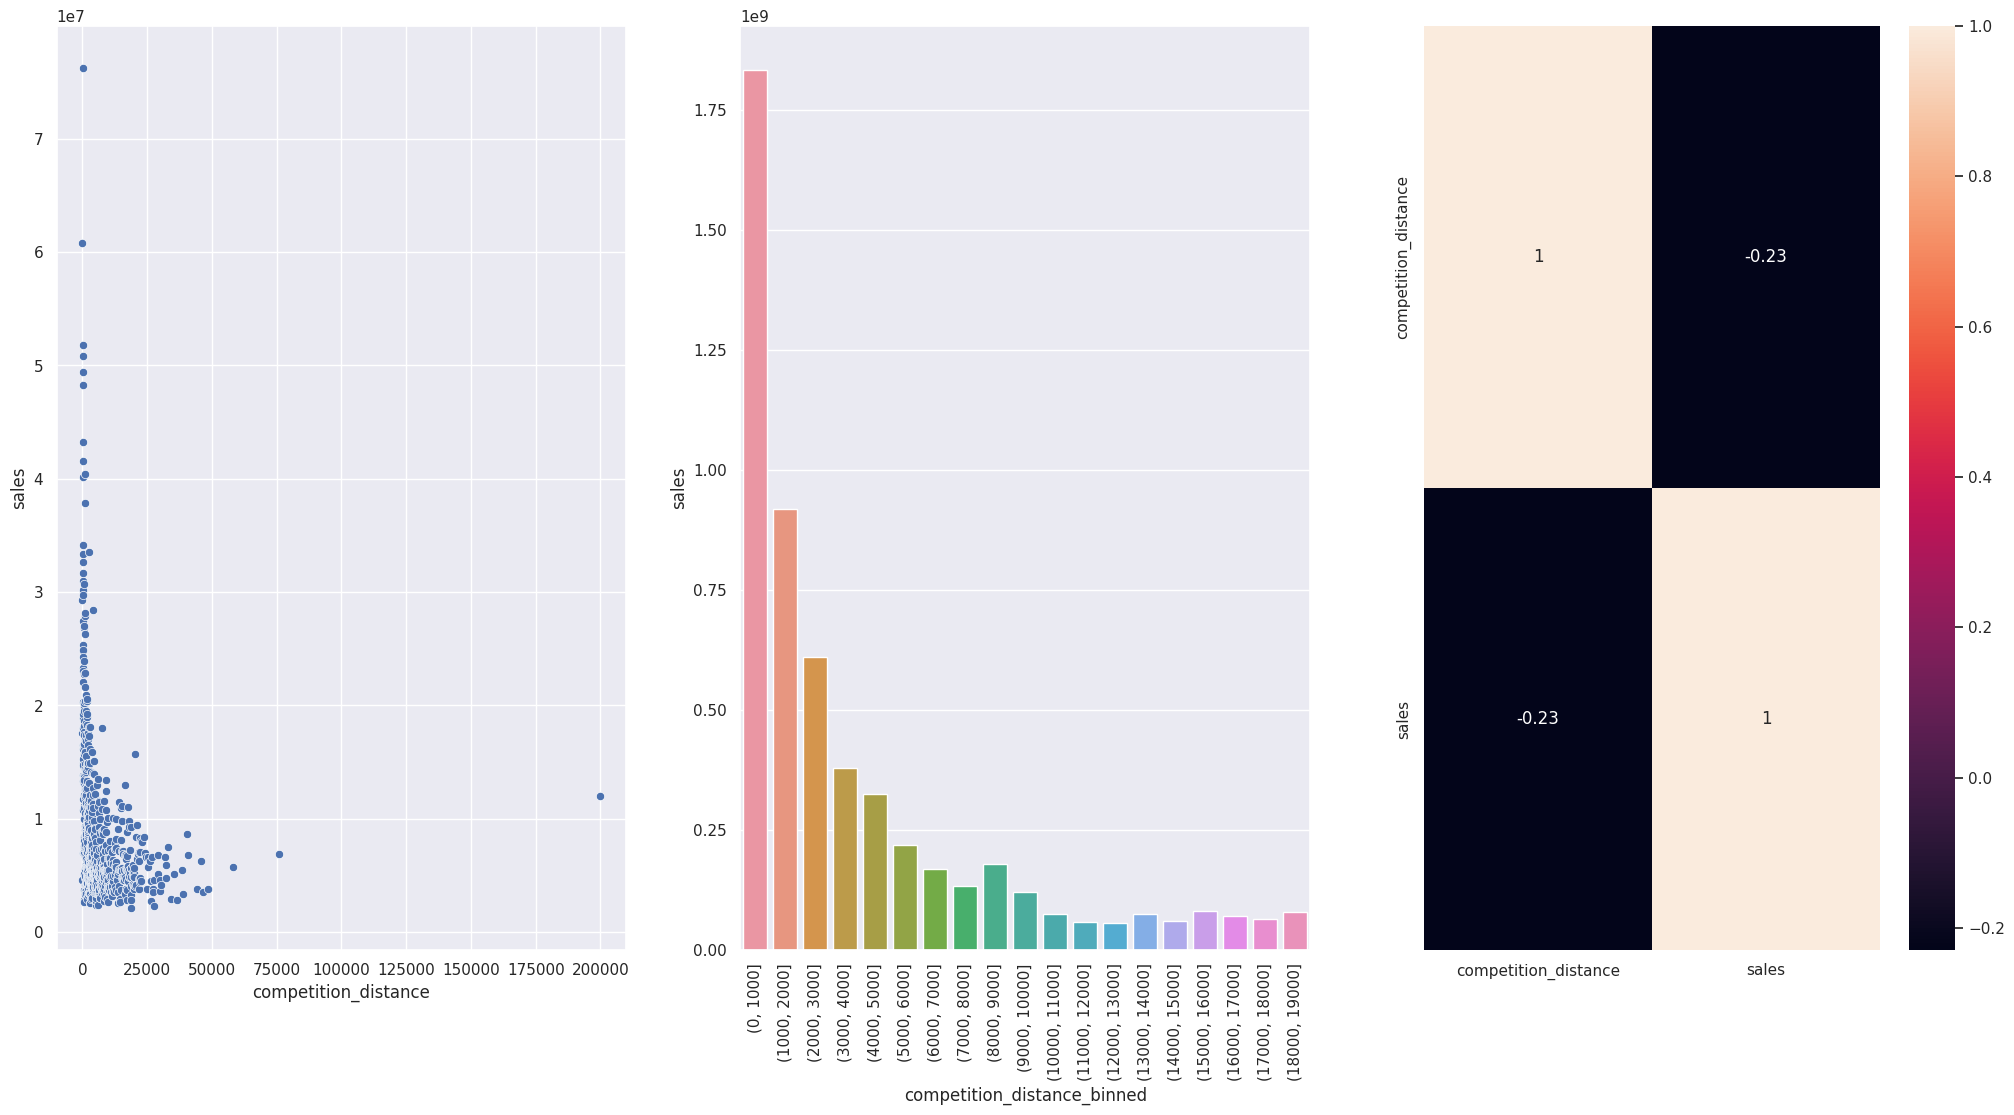

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
# bins seria a minha repartição em grupo da distancia de cada competidor
bins = list( np.arange(0,20000, 1000) )
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### **H3. Lojas com competidores à mais tempo deveriam vendem mais.**
**FALSA** Lojas com competidores recentes vendem MAIS

<AxesSubplot: >

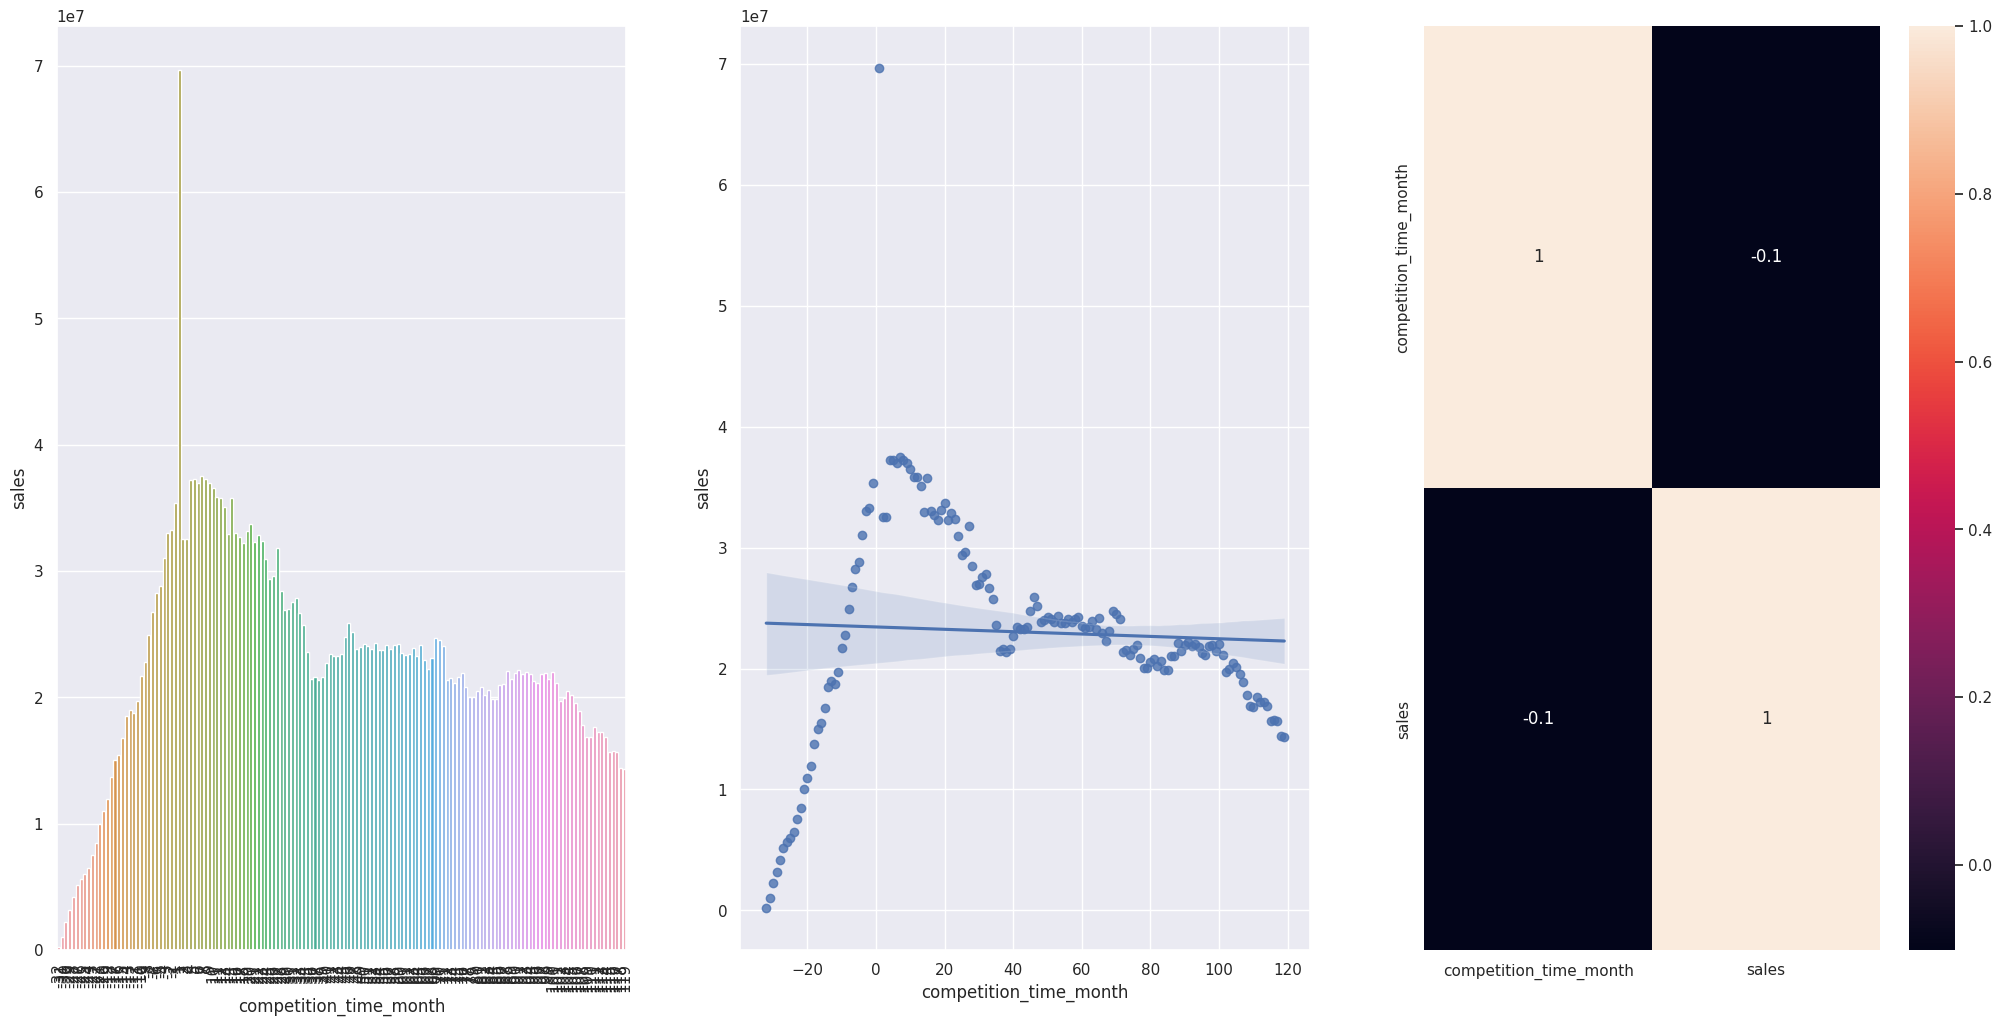

In [37]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data= aux2);
plt.xticks(rotation=90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção.


In [ ]:
## ASSUPTION: quando o valor no promo_time_week for negativo significa que a venda daquele dia ocorreu na promoção tradicional 
# e não na promoção extendida
# o feature promo_time_week foi montado com a date da venda - a ativação da promoção extendida

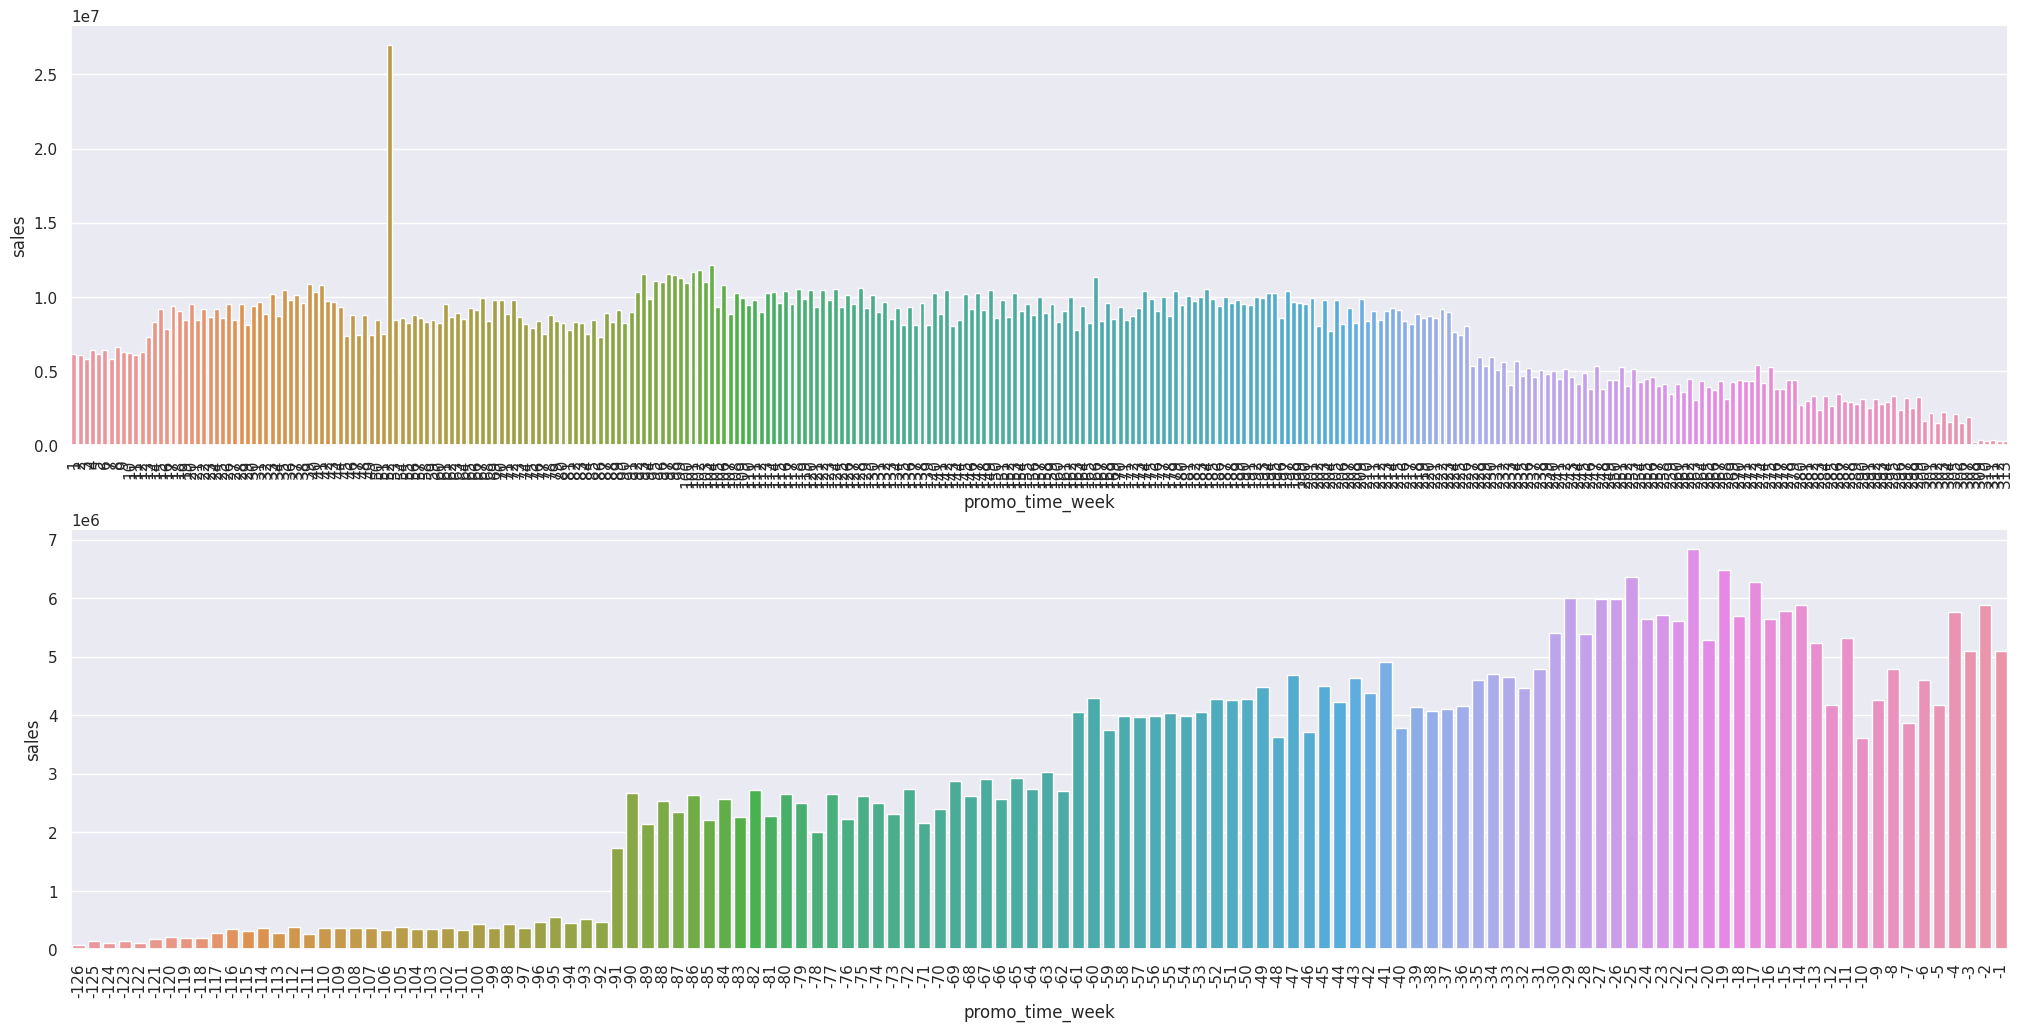

In [40]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# plot do somatorio das vendas na promo extendida
plt.subplot(2,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sns.barplot(x='promo_time_week', y= 'sales', data= aux2)
plt.xticks(rotation=90);

# plot do somatorio das vendas na promo regular
plt.subplot(2,1,2)
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sns.barplot(x='promo_time_week', y= 'sales', data= aux3)
plt.xticks(rotation=90);


Observações:
 * Gráfico 1: durante a promo extendida, podemos observar que durante um periodo ela se mantem com o seu somatorio de vendas regular. Depois de um periodo de tempo ocorre um decaimento.
 
 * Gráfico 2: Na promo tradicional, no seu inicio o somatorio de vendas é menor, aumentando conforme vai se aproximando a promo extendida. Podemos deduzir que pode ser o efeito de marketing para a promo extendida, ocasionando o aumento de vendas. 

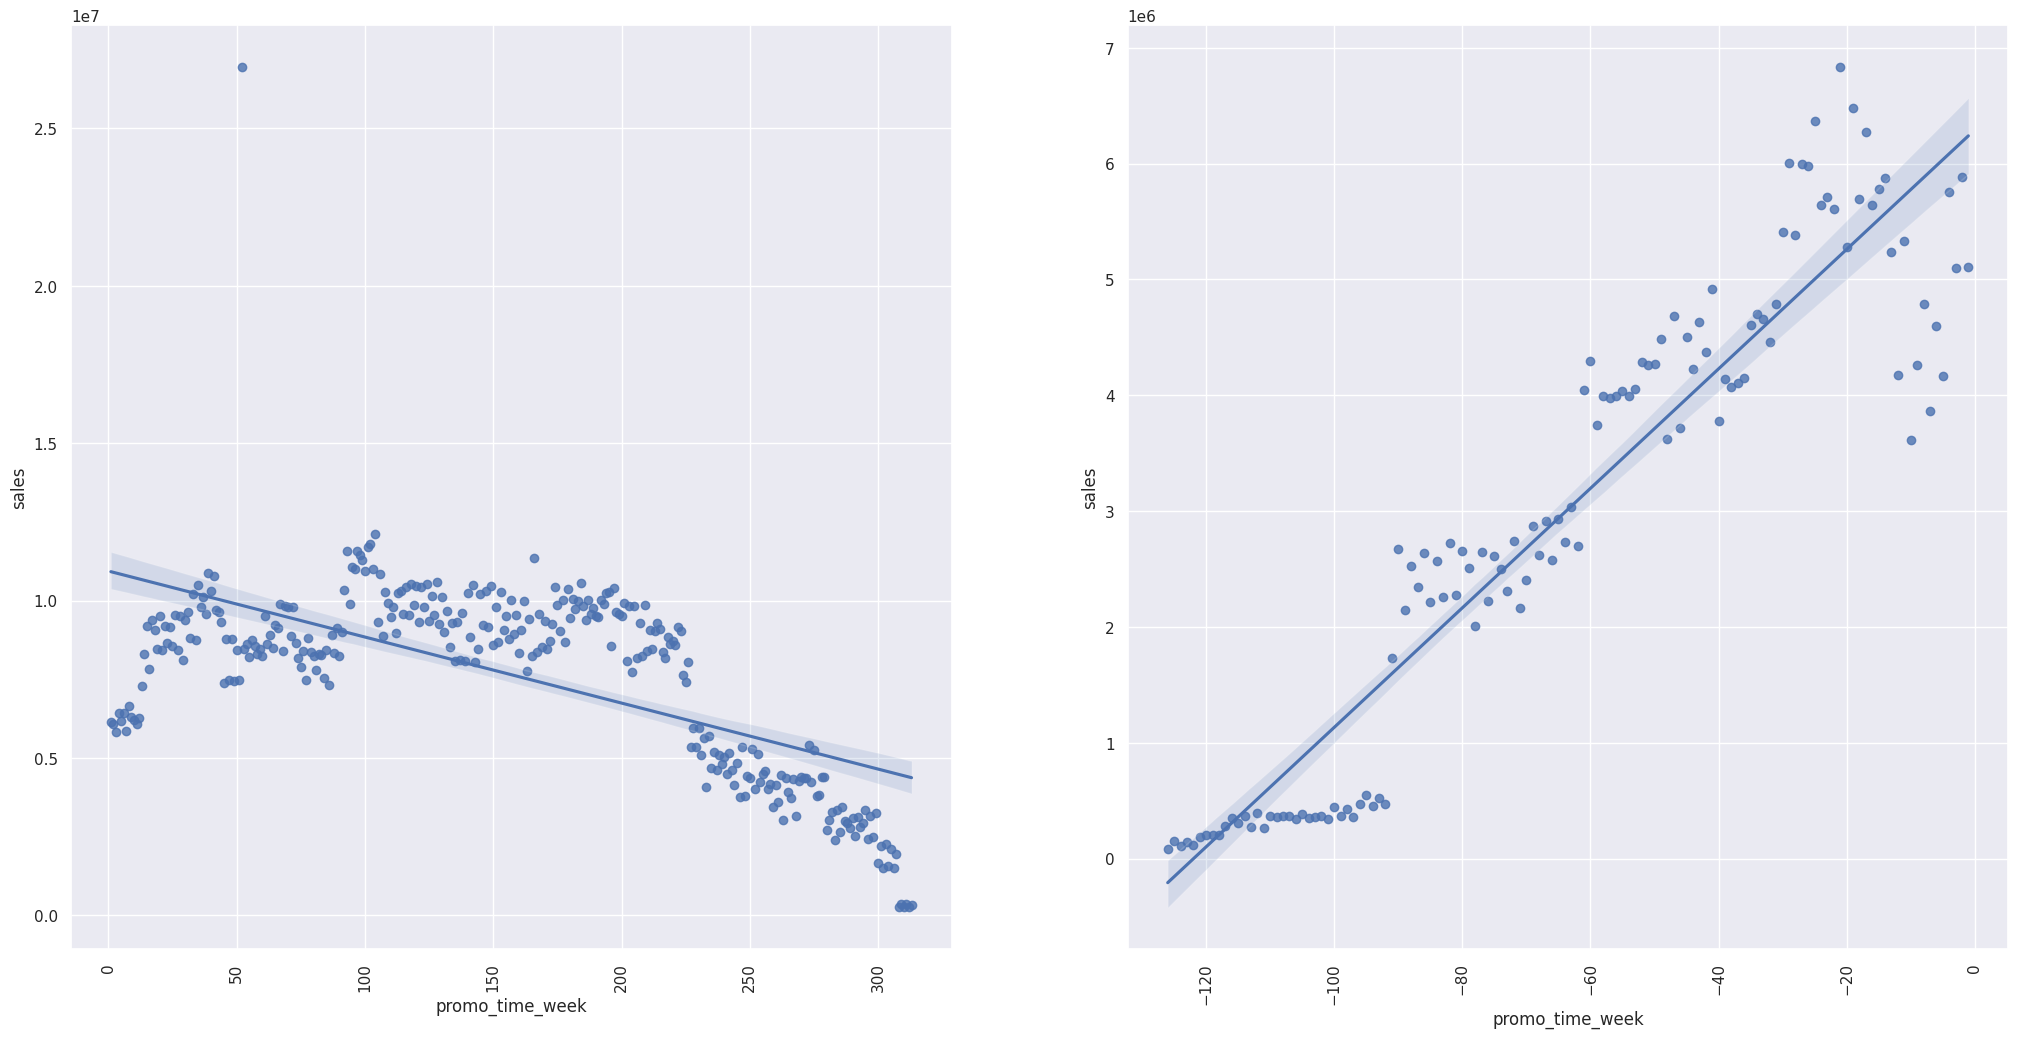

In [42]:
# confirmar a tendencia dos graficos
# tendencia da promo extendida
plt.subplot(1,2,1)
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

# tendecia da promo tradicional/regular
plt.subplot(1,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

Observação:

    - Grafico 1 - tendencia de queda na promo extendida ao longo do tempo
    - Grafico 2 - tendencia de subida na promo tradicional ao longo do tempo

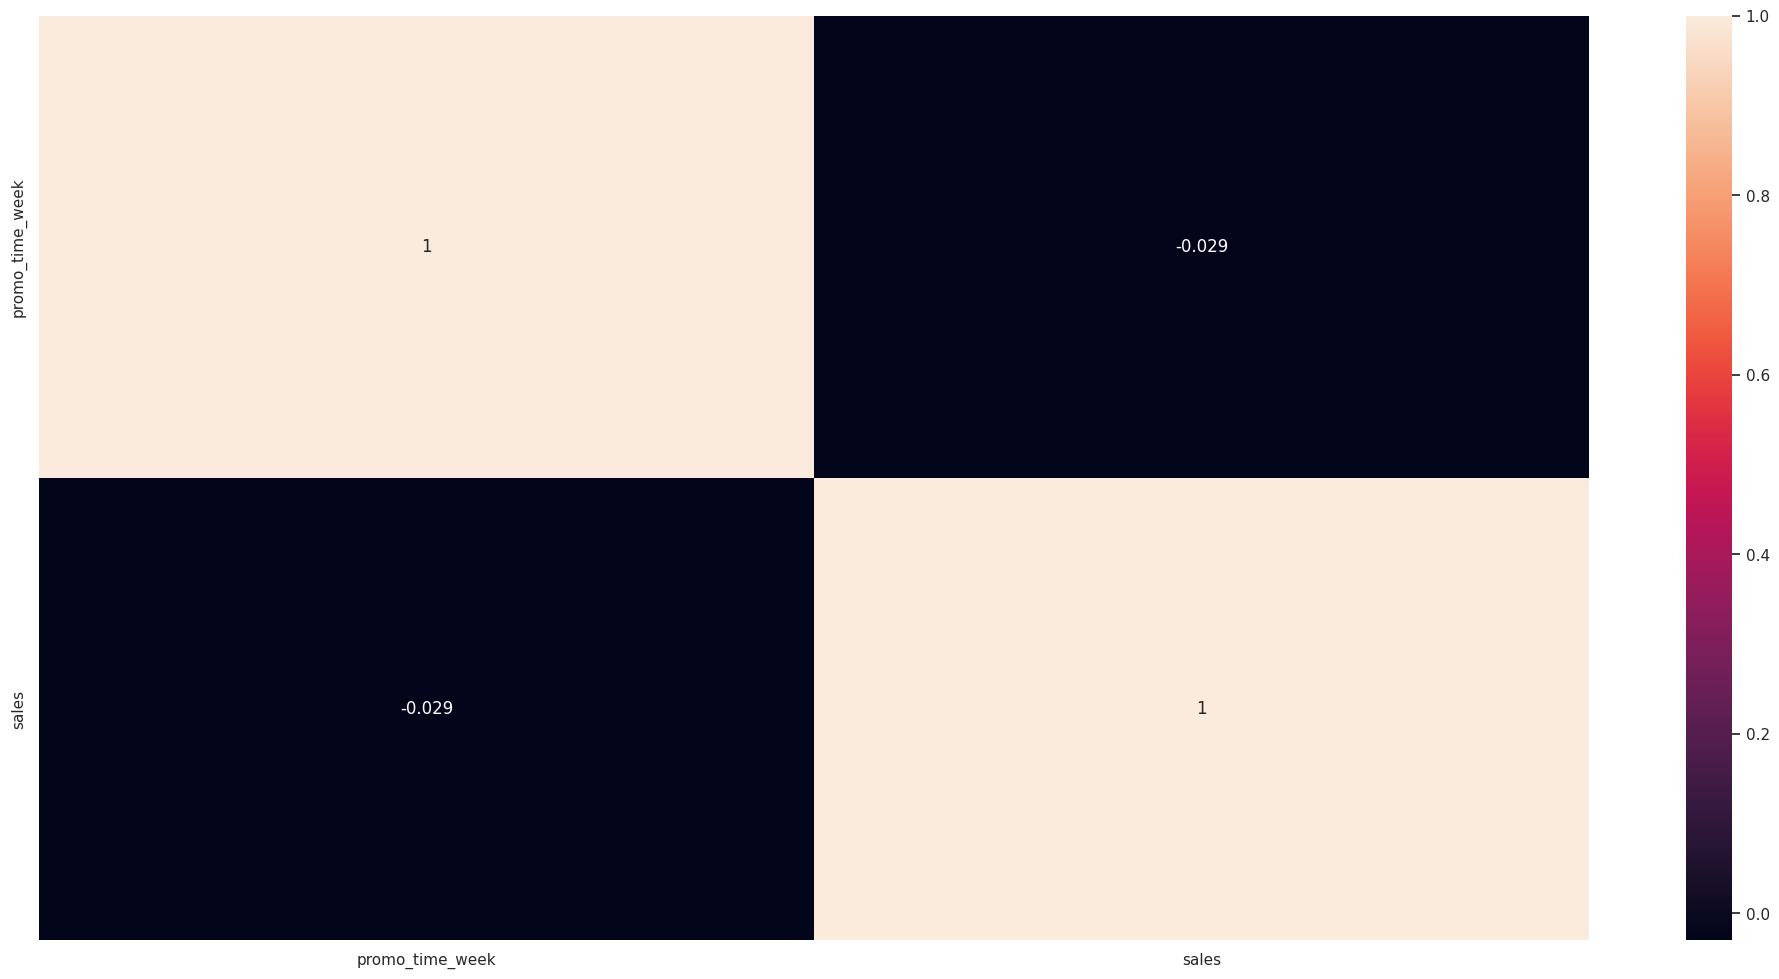

In [44]:
# observando a correlação através do heatmap
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Heatmap: corelação muito baixa -0,029 com as vendas. 

Logo, essa feature pode ter uma baixa relevancia para o modelo de predição de vendas.

#### <s>**H5. Lojas com mais dias de promoção deveriam vender mais.**</s>
Deixa para o próximo ciclo do CRISP - tal validação de hipotese deve criar mais uma feature de tempo em dias da promoção.


#### **H6. Lojas com mais promoções consecutivas deveriam vender mais.**
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [46]:
# agrupando o somatorio de vendas durante a promo e a promo2(consecutiva)
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=True)


,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


Observação da tabela:
* a maior quantidade de vendas foi apenas quando há promo. 
* a promo2 (consecuutiva) não é o maior valor de vendas

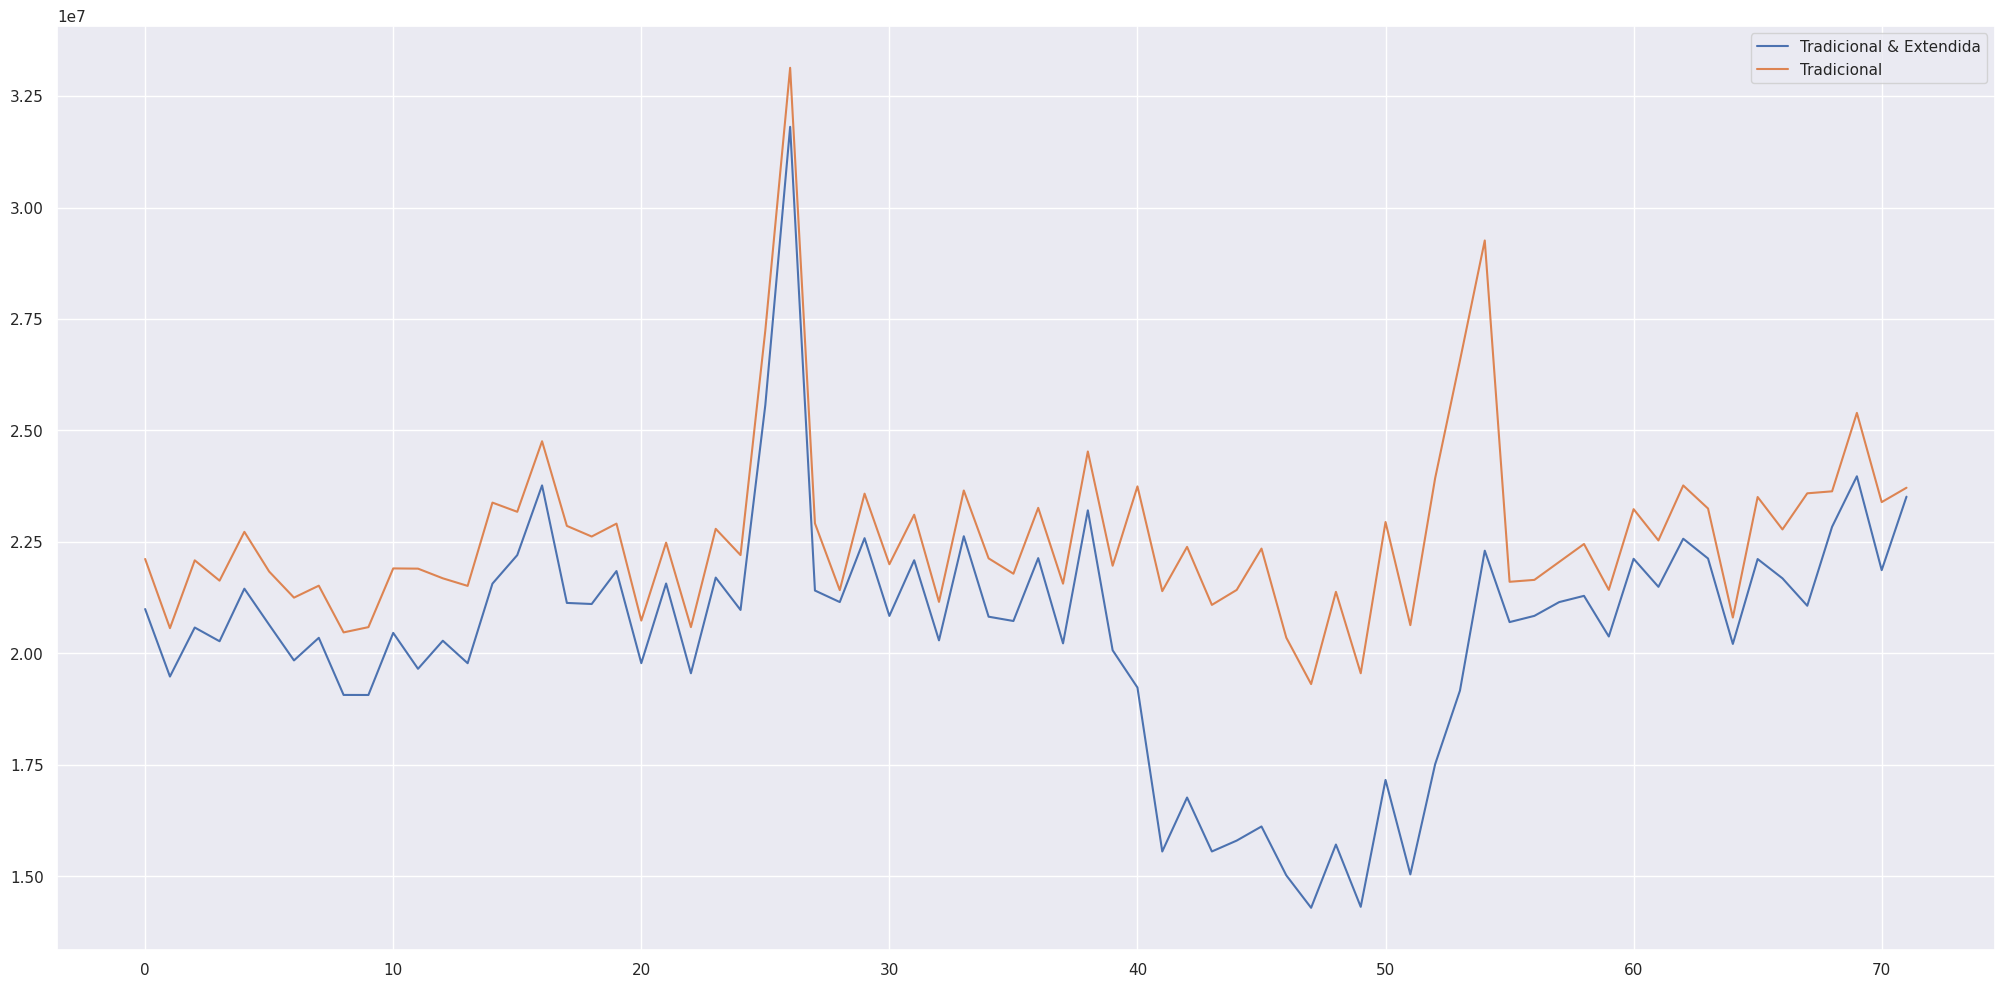

In [48]:
# observando ao longo do tempo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);


#### **H7. Lojas abertas durante o feriado de Natal deveriam vender mais.**
**FALSA** 

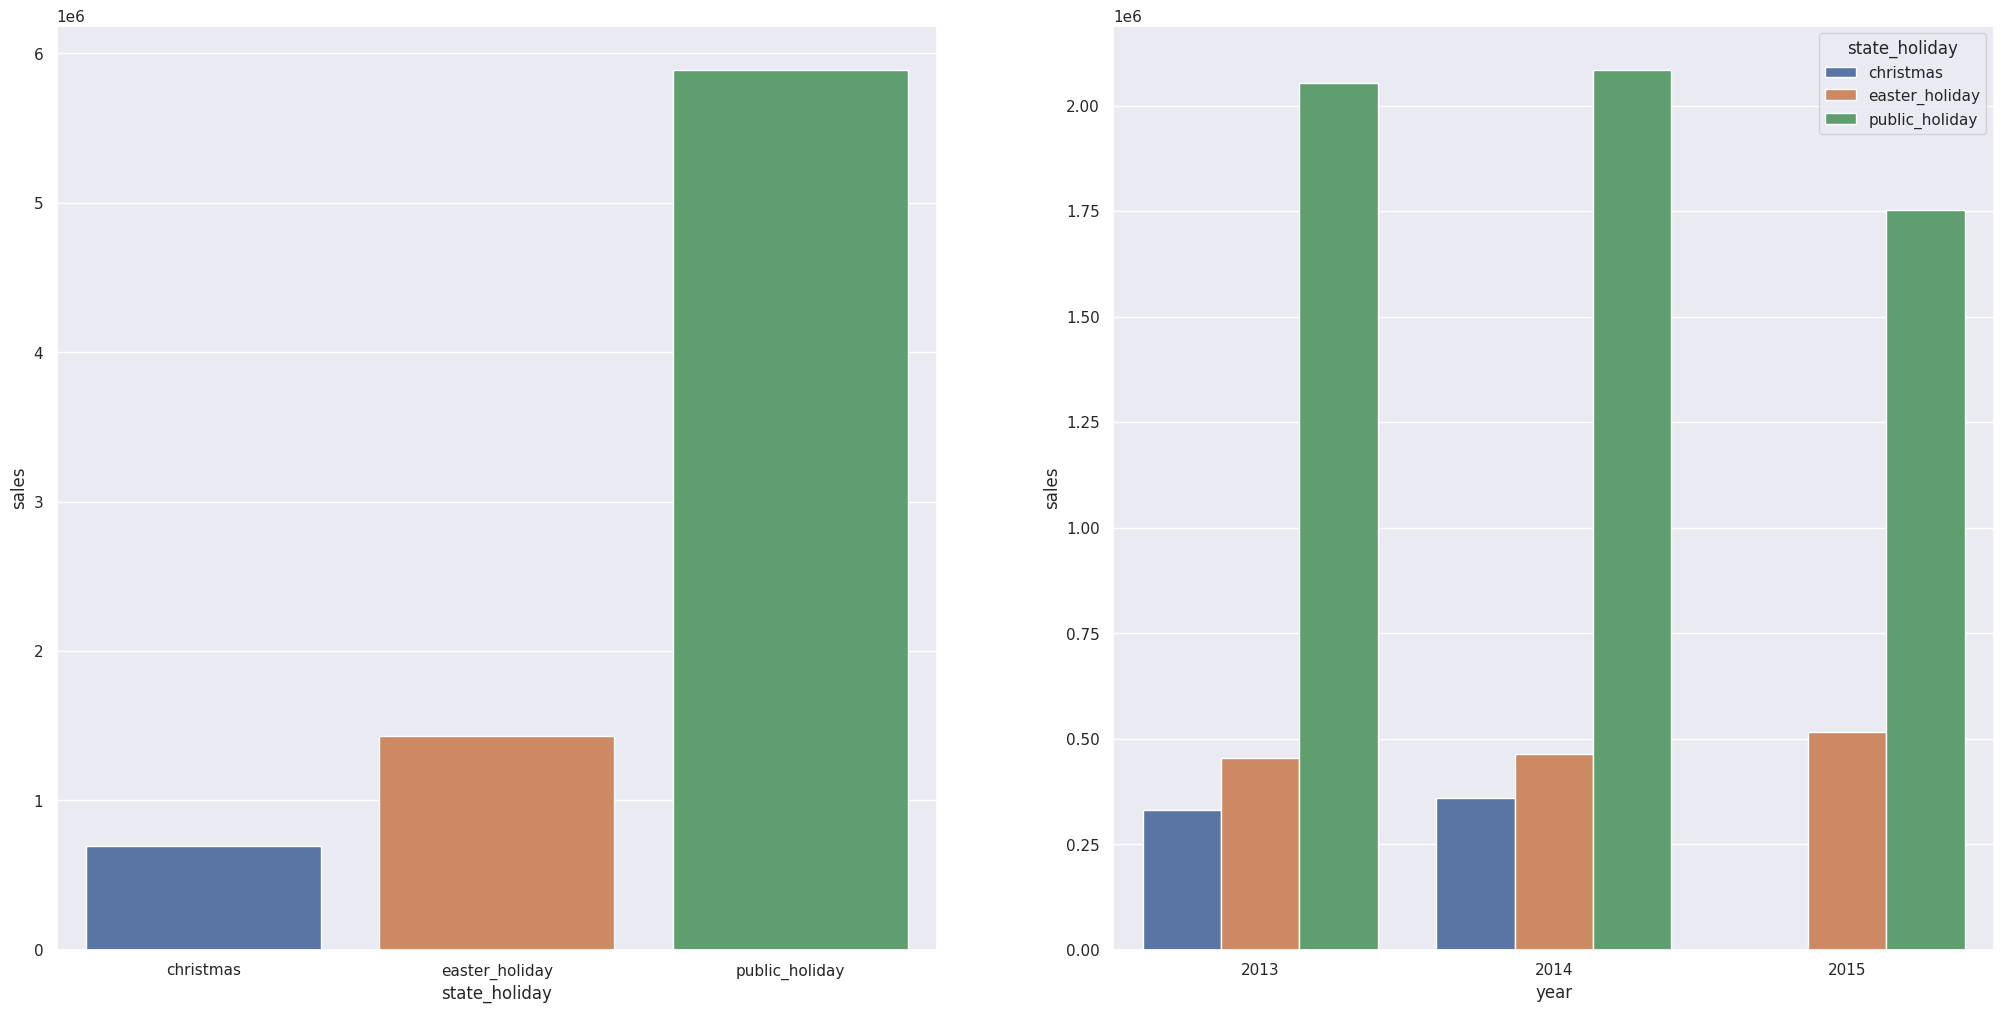

In [53]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

#### **H8. Lojas deveriam vender mais ao longo dos anos.**
**FALSA** Lojas vendem ao longo dos anos

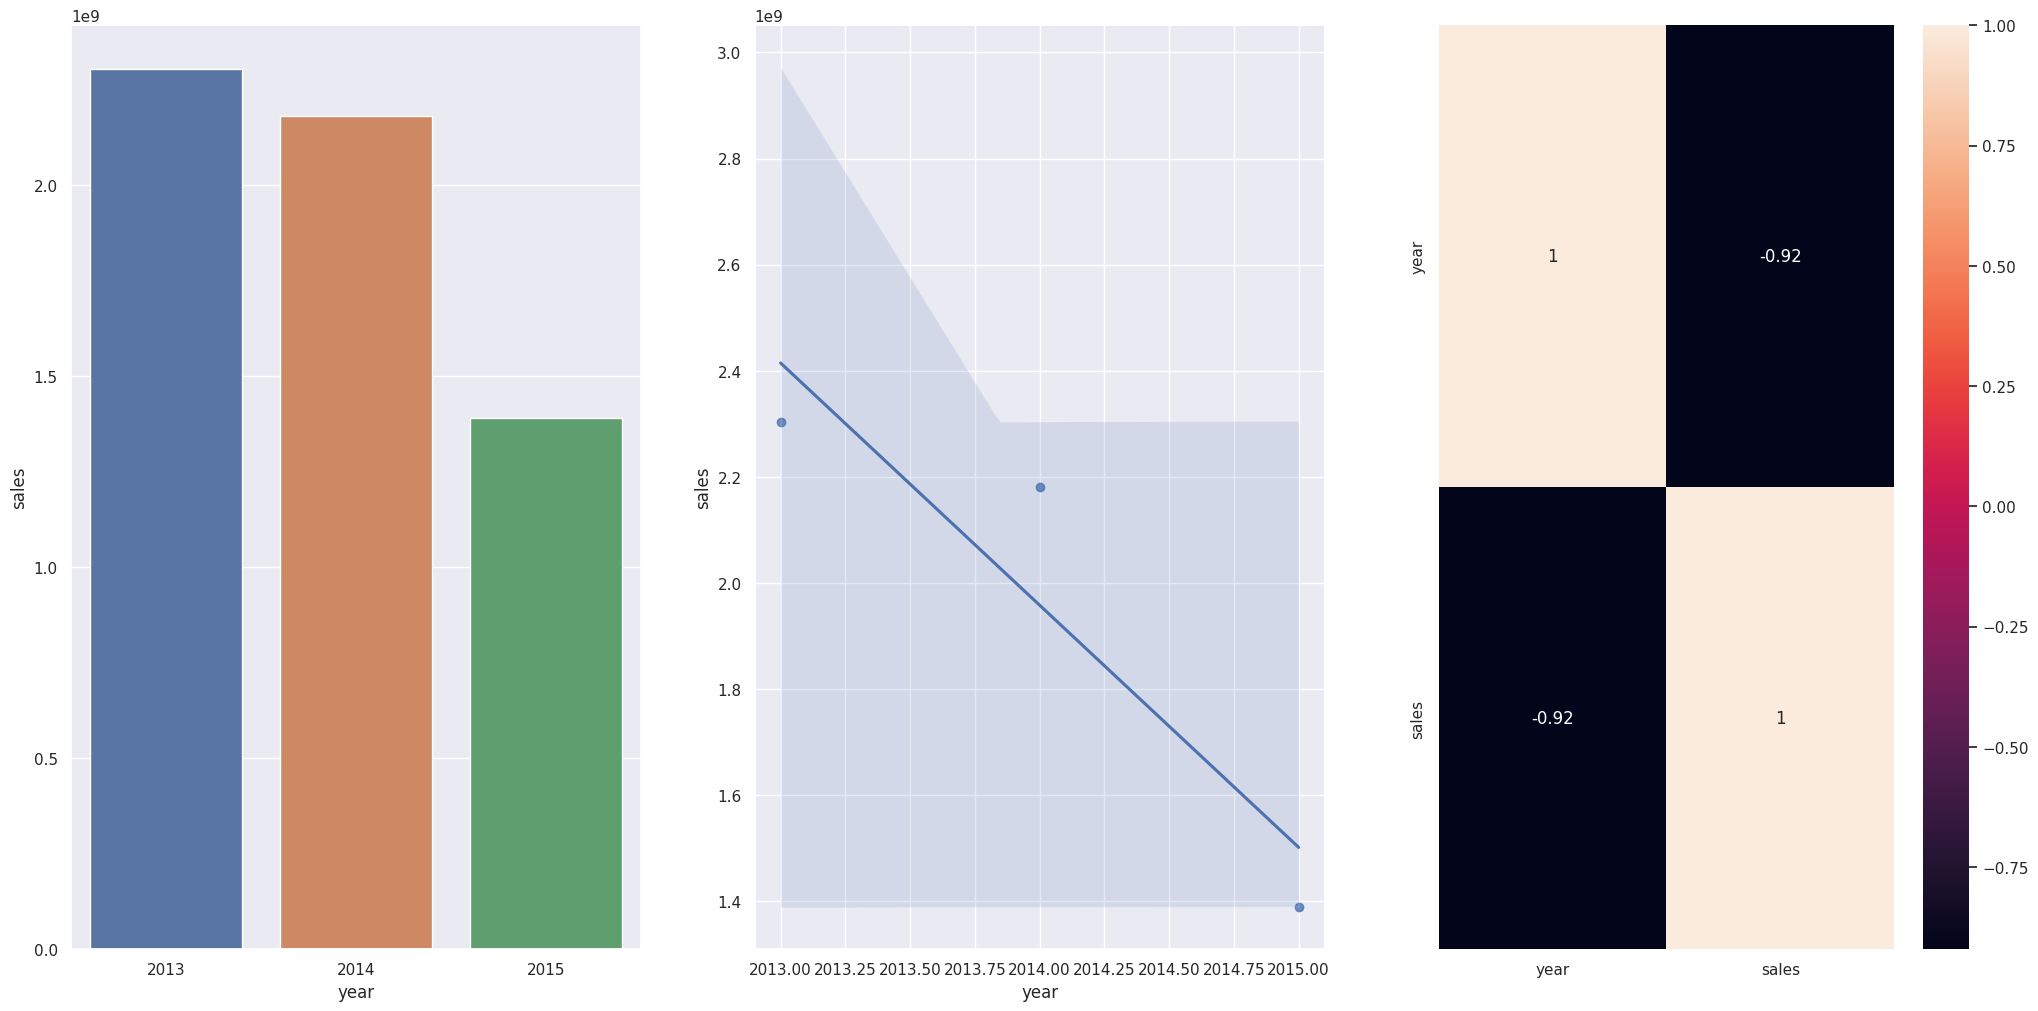

In [55]:
plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H9. Lojas deveriam vender mais no segundo semestre do ano.**
**FALSA** Vendem menos no segundo semestre.

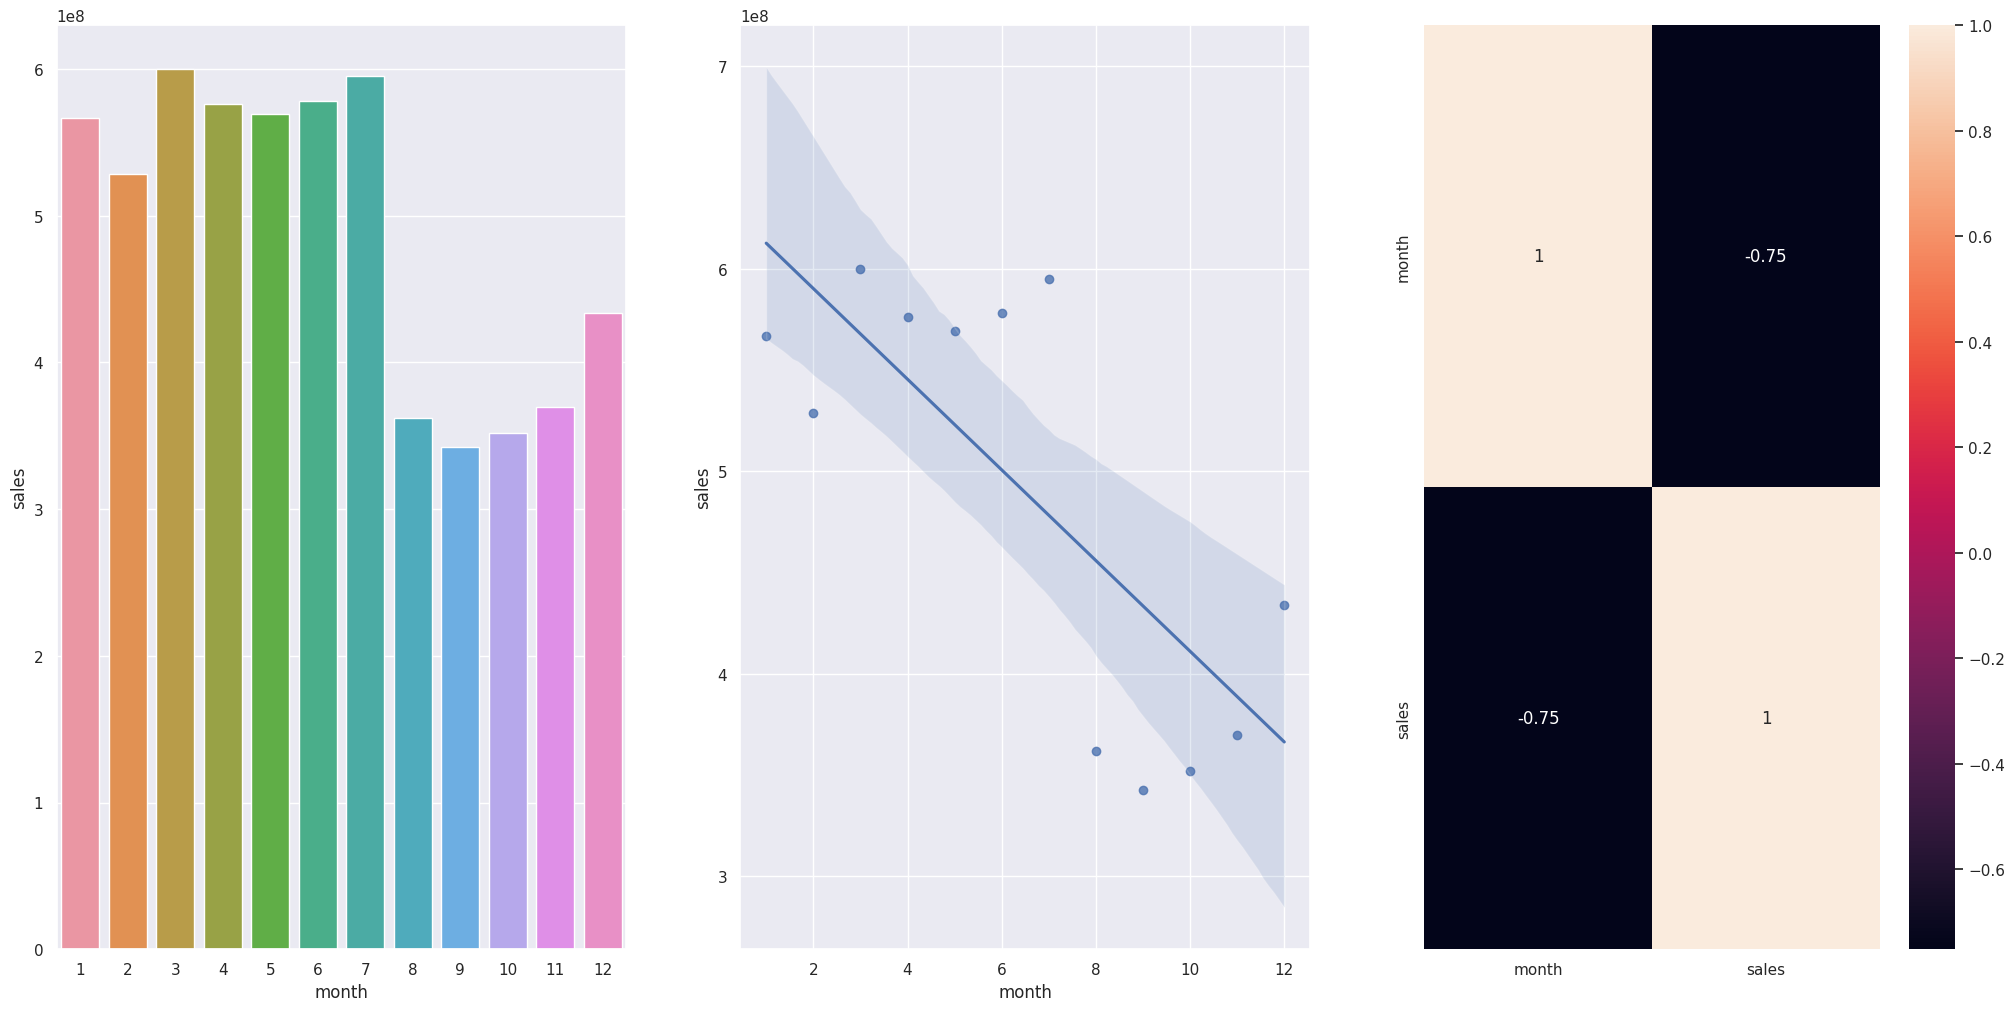

In [57]:
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Observação:
* No segundo semestre ocorre um decaimento.

#### **H10. Lojas deveriam vender mais depois do dia 10 de cada mês.**
**VERDADEIRO**

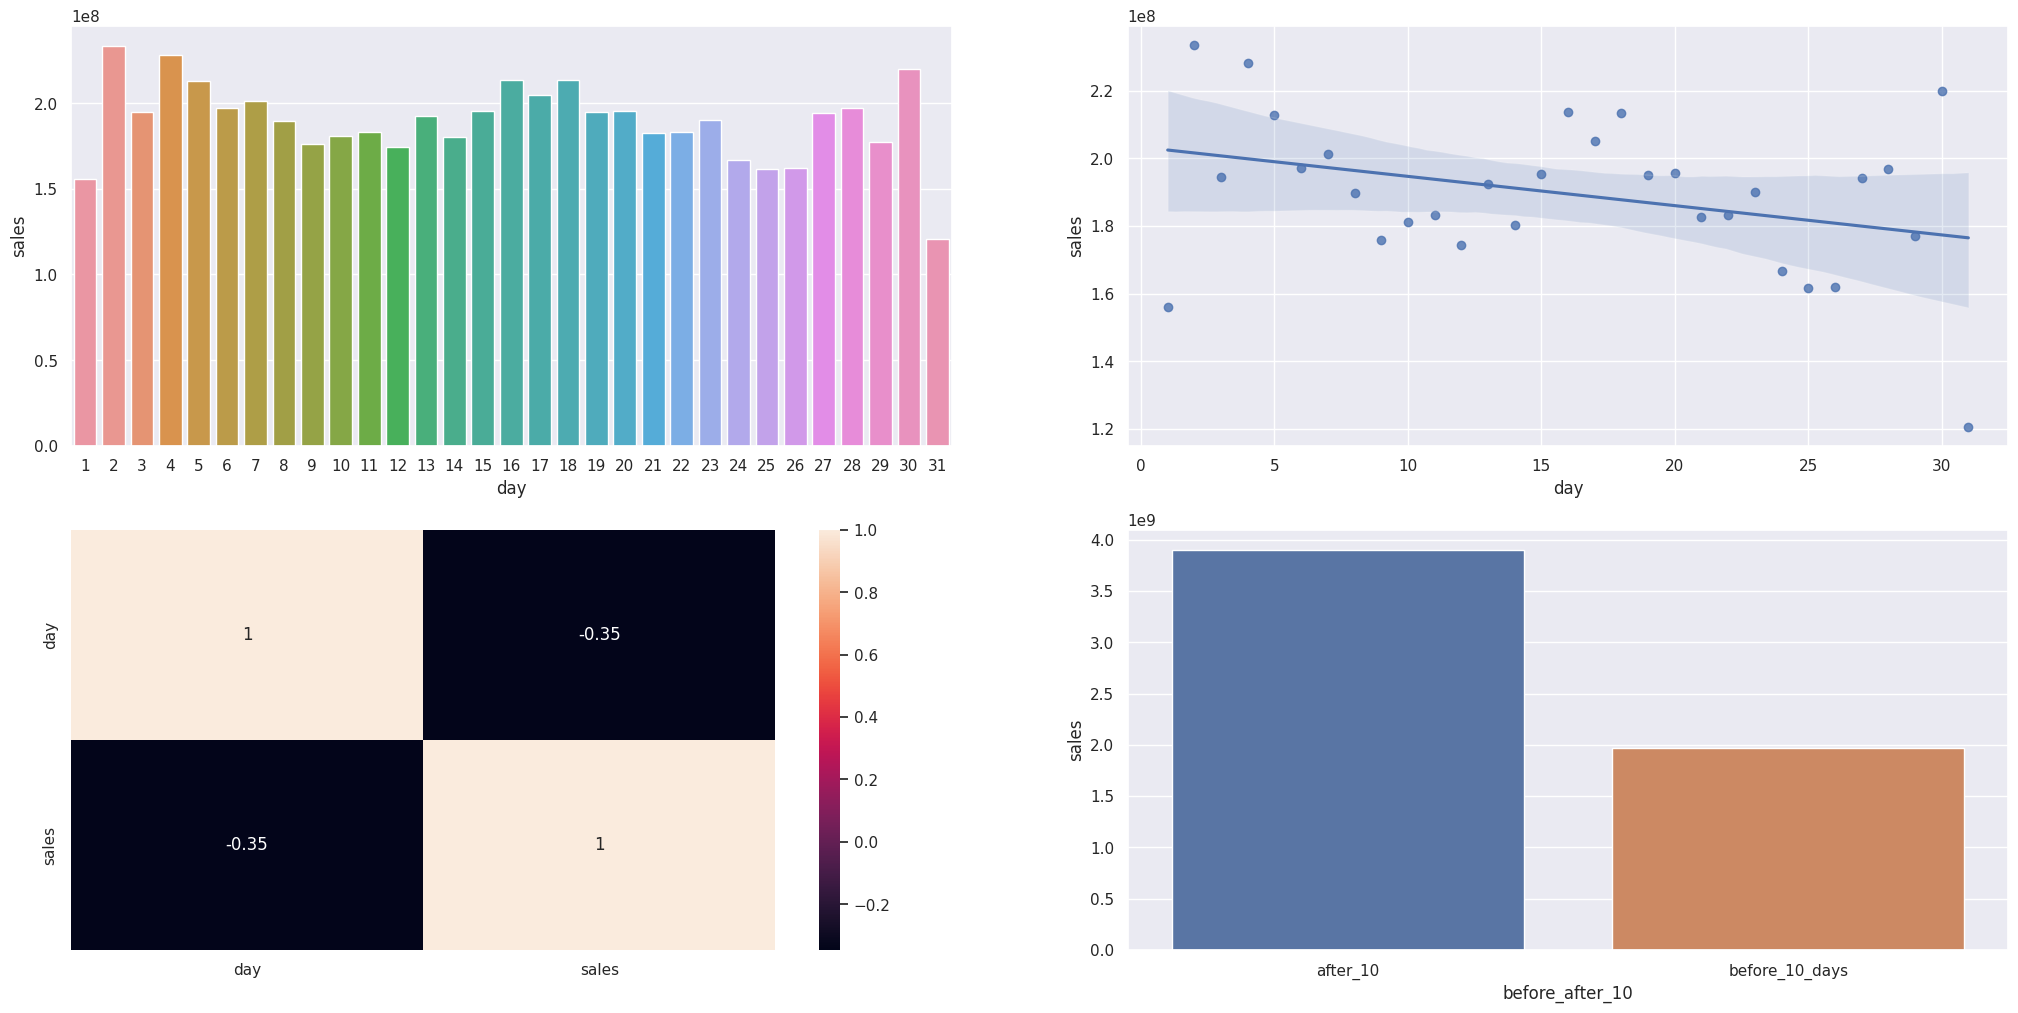

In [59]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10')
aux2 = aux1[['before_after_10','sales']].groupby('before_after_10').sum().reset_index()
sns.barplot(x='before_after_10', y='sales', data=aux2);

#### **H11. Lojas deveriam vender menos aos finais de semana.**
**VERDADEIRO**

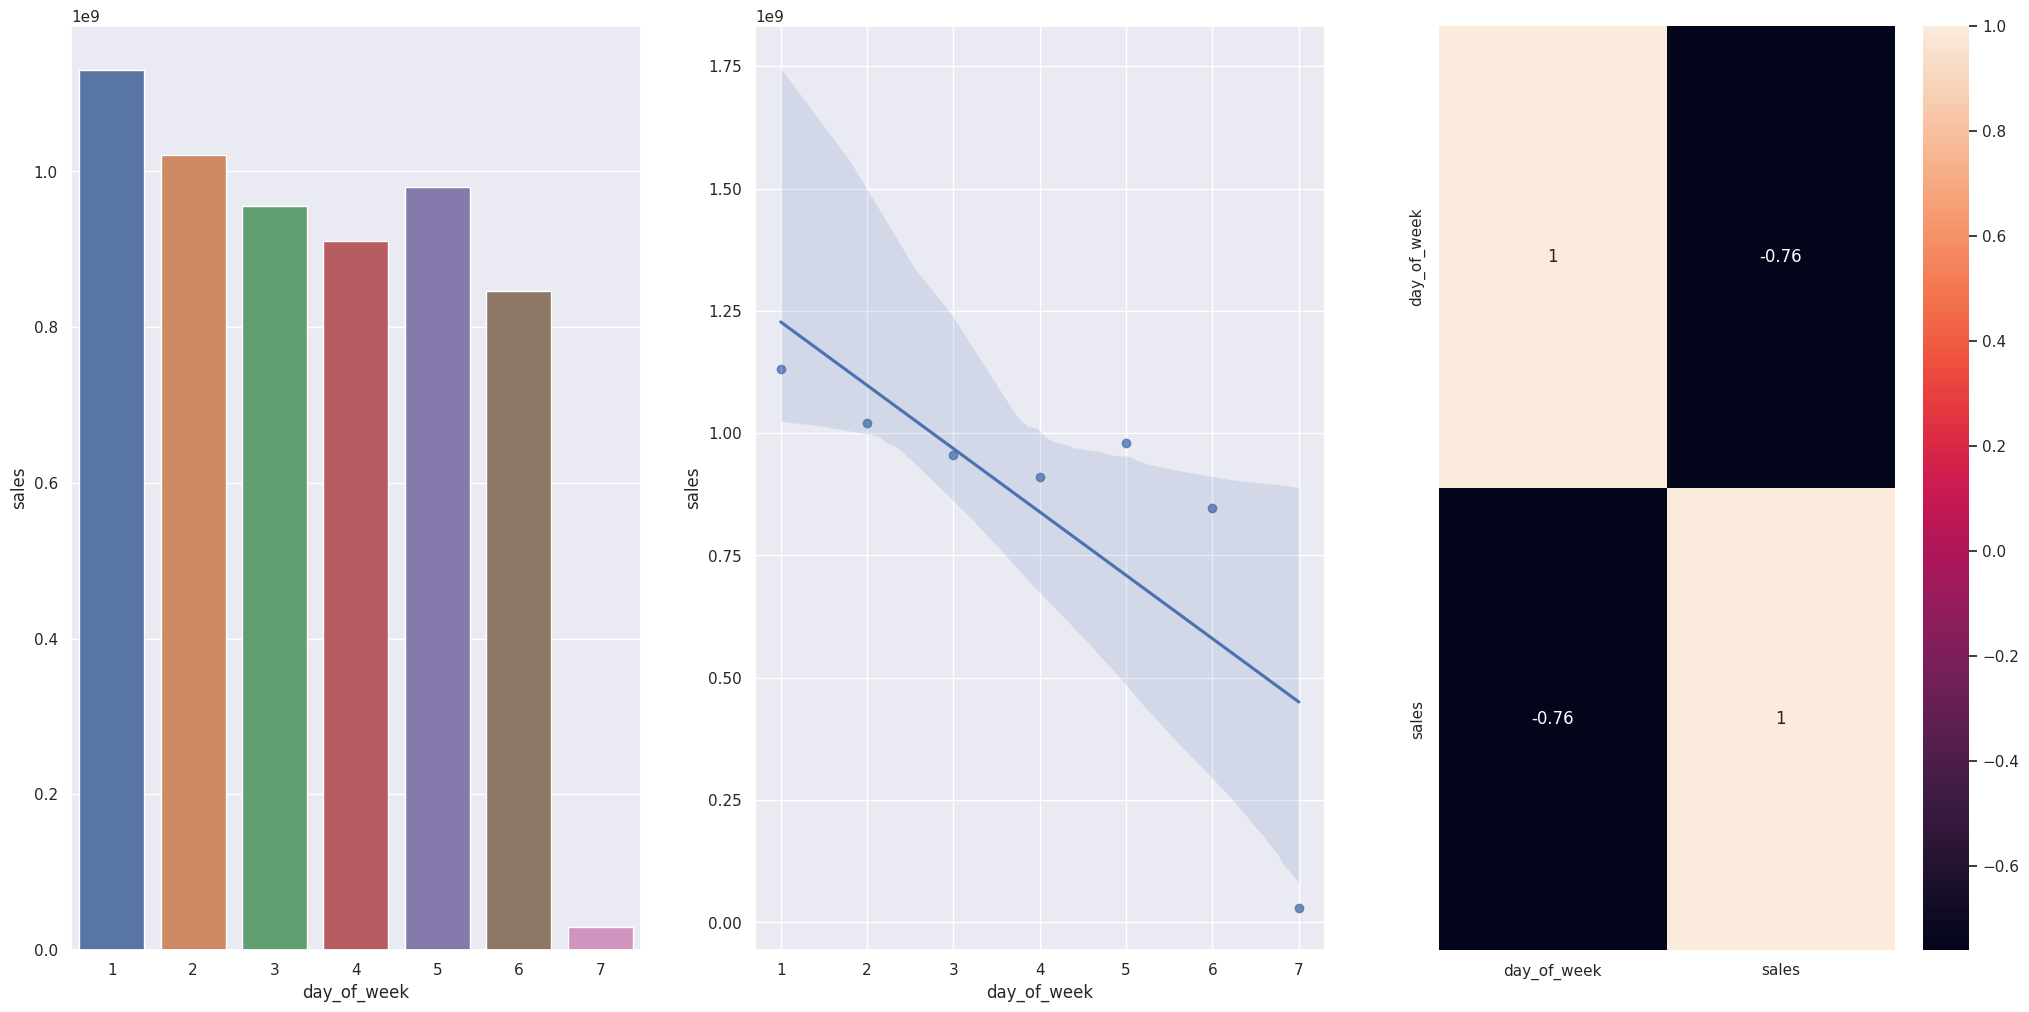

In [61]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H12. Lojas deveriam vender menos durante os feriados escolares.**
**VERDADEIRO** Exceto nos meses Julho e agosto, periodo de ferias. 

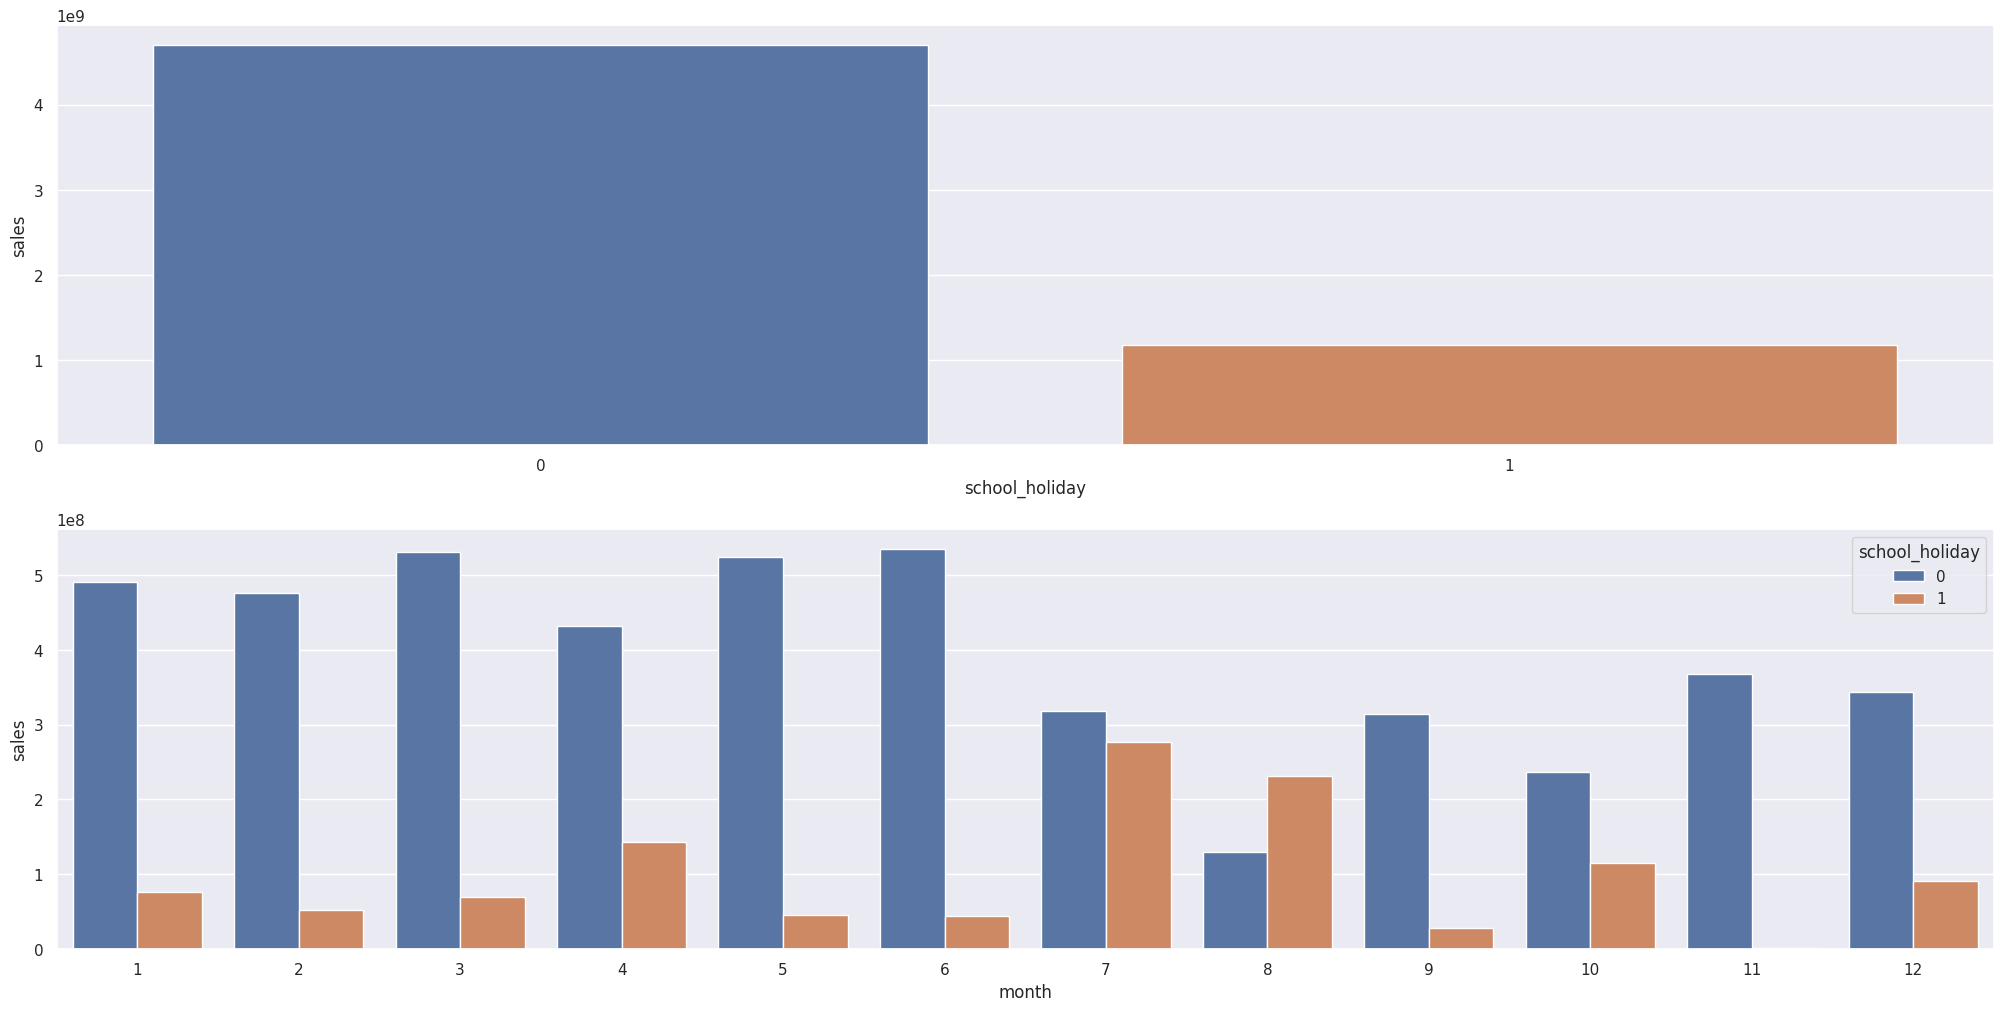

In [63]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

Observação:
* No grafico 1 temos que deixar claro que o total de feriado é menor que os dias regulares escolar, por isso o somatorio de vendas é maior.
* Grafico 2 - já mostra essa relação mes por mes. No mes 7 e 8 é periodo de ferias.

## 4.3 Análise Multivariada